# Capstone Project - Analysis of the Corona pandemic
In this project, data from the ongoing “Corona” pandemic is analyzed. The SARS-CoV-2 virus has spread around the world in a relatively short time after its first apperance in Wuhan (China) and the caused disease COVID-19 (=coronavirus disease 2019) stresses the healthcare systems in many countries. Here, the growth over the time after start of the outbreak in the different countries is visualized and measures are introduced to compare the intensities of the outbreaks. Furthermore, it is checked whether there are specific driving forces for the exponential growths and effective measures against.

Therefor, two datasets are analyzed that are later on combined to one:

1. One dataset has been taken from the CSSE at Johns Hopkins University: It shows timeseries regarding cumulative Corona cases of all affected countries. The data has been taken from the following GitHub repository. Please note, that the data is updated every day. Thus, there might be effects on the conclusion in a few weeks. For this analysis, data taken on May 1st, 2020 has been used (stored in DataScience_Project4 GitHub): https://github.com/CSSEGISandData/COVID-19/edit/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

2. Another dataset has been downloaded from Kaggle. It gives an overview on different Corona-related information for the affected countries: https://www.kaggle.com/koryto/countryinfo#covid19countryinfo.csv

More information on the background and a discussion of the results can be found in my corresponding [blog post](https://mirods.github.io/project4.html).

## 1. Questions
There are a number of questions for which this analysis should give answers or at least some hints.

* Question 1: How can the data be prepared so that outbreaks in different countries can be visualized?
* Question 2: What could be measures to compare the outbreaks in the different countries?
* Question 3: What are the effects of the initial situations in the different countries on the outbreak intensity?
* Question 4: Is it possible to make predictions on the development of the disease?

## 2. Data understanding
The data is loaded and a number of things are checked to understand the datasets.


In [1]:
# Import required packages
import numpy as np
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline
import math
from datetime import date # Required to deal with dates in the data
from scipy.signal import savgol_filter # Implements specific filter (Savitzky-Golay) to smooth statistical fluctuations
from scipy.signal import medfilt # Implements median filter
from sklearn.ensemble import RandomForestRegressor # Implements used regression method

# Set output options in a way that all columns and rows of the used datasets are visible
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 1000)

# Read in the datasets
df_timeseries = pd.read_csv('./time_series_covid19_confirmed_global.csv') # Read in timeseries data
df_countryinfo = pd.read_csv('./covid19countryinfo.csv') # Read in country information data


In [2]:
# Parameters
# The following parameters influence some of the analysis steps.
# They are defined here to ensure consistent parameter values in the analysis.

# Define the outbreak threshold: The day the value is reached is "day 1"
outbreak_threshold = 10

# Penality costs if a measure against the outbreak has not been used
penality = 50

# Minimal length of the exponential growth phase of an outbreak
# (till inflection point)
minimal_exponential_phase = 7

### Check the timeseries data

In [3]:
# Show the timeseries data
df_timeseries.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  \
0       0       0       0       0       0       0       0       0        0   
1       0       0       0       0       0       0       0       0        0   
2       0       0       0       0       0       0       0       0        0   
3       0       0       0       0       0       0       0       0        0   
4       0       0       0       0       0       0       0       0        0   

   2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  \
0        0        0        0        0        0        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        1        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  \
0        1        1        1       1       1       1       1       1       1   
1        0        0        0       0       0       0       0       0       0   
2        1        1        1       1       3       5      12      12      17   
3        0        0        0       0       1       1       1       1       1   
4        0        0        0       0       0       0       0       0       0   

   3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  \
0       1       4       4        5        7        7        7       11   
1       0       0       2       10       12       23       33       38   
2      17      19      20       20       20       24       26       37   
3       1       1       1        1        1        1        1        1   
4       0       0       0        0        0        0        0        0   

   3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  \
0       16       21       22       22       22       24       24       40   
1       42       51       55       59       64       70       76       89   
2       48       54       60       74       87       90      139      201   
3        1        2       39       39       53       75       88      113   
4        0        0        0        0        0        1        2        2   

   3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  3/29/20  3/30/20  \
0       40       74       84       94      110      110      120      170   
1      104      123      146      174      186      197      212      223   
2      230      264      302      367      409   

In [4]:
print('The dataset contains', df_timeseries.shape[0], 'rows and', df_timeseries.shape[1], 'columns.')

The dataset contains 266 rows and 105 columns.


In [5]:
df_timeseries['Country/Region'].value_counts()

China                               33
Canada                              15
France                              11
United Kingdom                      11
Australia                            8
Netherlands                          5
Denmark                              3
Madagascar                           1
Serbia                               1
Haiti                                1
Benin                                1
Paraguay                             1
Kuwait                               1
Seychelles                           1
Egypt                                1
Morocco                              1
Argentina                            1
Angola                               1
Hungary                              1
India                                1
Jordan                               1
Nigeria                              1
Portugal                             1
Djibouti                             1
Mexico                               1
Libya                    

The timeseries contains the number of Corona cases for 266 countries/regions for a time period beginning on January 22, 2020. In some cases, there is a differentiation between different provinces/states of a country, e.g. 33 different ones for China. Furthermore, the latitude and longitude of the countries are shown.

In the next step, the number of cases are plotted. Thereby, the countries with the highest number of cases at the end of the timeseries are shown. Before, the visualization functionality is implemented into a function which will be reused later.

In [6]:
def visualize_timeseries(df, logy_scale):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    number_of_top_countries - Number of countries with the highest number of cases which are visualized
    
    Description:
    The input timeseries is visualized in a line chart.
    Before, the data is prepared so that it can be used to call the plotting function.
    '''
    
    # Remove nan values
    if 'Province/State' in df:
        df['Province/State'].fillna("", inplace=True)

    # Add a column country that combines Country/Region and Province/State (if not already done)
    if not('Country' in df):
        df['Country'] = df['Country/Region'] + " " + df['Province/State']

    # Define the country column as the new index (later on shown in the plot legend)
    df.set_index('Country', inplace=True)

    # Delete all columns which are not needed for the plot (everything which is not part of the timeseries)
    values_found = False
    for col_name, col_data in df.iteritems():
        if col_name == '1' or col_name == '1/22/20':
            values_found = True
        if not(values_found):
            del df[col_name]
                
    # The following columns will be added during the analysis.
    # However, they shall not be plotted if this function is called in later steps.
    if 'Max_Value' in df:
        del df['Max_Value']
    if 'Max_Index' in df:
        del df['Max_Index']
        
    # Exchange rows and columns which is required for the plot function (in line charts columns are plotted)
    df = df.transpose()
    
    # Create plot
    plt.style.use('seaborn') # Define style  
    df.plot(kind = 'line', legend = True, logy = logy_scale, mark_right = True)
    plt.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5)) # Show legend outside of the plot
    plt.show()

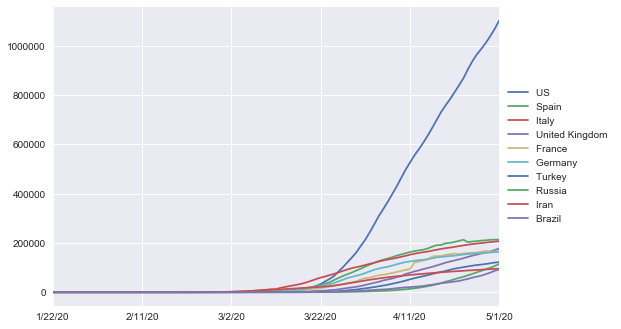

In [7]:
# Visualize the 10 countries with the highest number of infections (sorted ascendingly and select top 10)
visualize_timeseries(df_timeseries.sort_values(by = df_timeseries.columns[-1], ascending = False).head(10), False)

The plot above shows the typical chart maybe known from news coverage. It shows exponential growth curves. They change to more linear curves after some time which is clearly visible e.g. for the US. Some curves e.g. France show a saltus (possibly after later corrections of case numbers).

The following plot zooms into the time axis and shows only the development till end of March to give a better view on the exponential growth. Here it is clearly visible that China shows an uncommon development of the disease. There is a second strong increase of case numbers followed by a phase where no new cases occur.

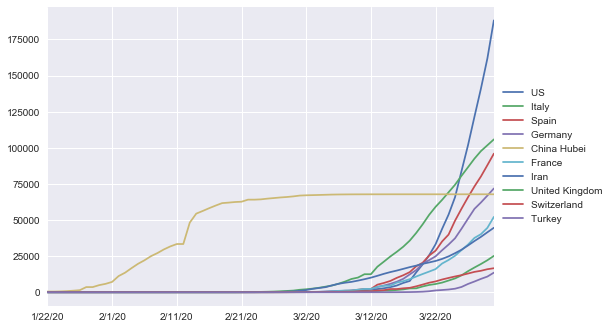

In [8]:
# Copy timeseries data
df_timeseries_cut=df_timeseries.copy()

# Remove data which shall not be plotted
values_found = False
for col_name, col_data in df_timeseries_cut.iteritems():
    if col_name == '4/1/20':
        values_found = True
    if values_found:
        del df_timeseries_cut[col_name]

# Visualize the 10 countries with the highest number of infections (sorted ascendingly and select top 10)
visualize_timeseries(df_timeseries_cut.sort_values(by = df_timeseries_cut.columns[-1], ascending = False).head(10), False)

### Check the country information data

In [9]:
# Show countryinfo
df_countryinfo.head()

region              country alpha3code alpha2code         pop  tests  \
0    NaN          Afghanistan        AFG         AF  38,928,346    NaN   
1    NaN              Albania        ALB         AL   2,877,797    NaN   
2    NaN              Algeria        DZA         DZ  43,851,044    NaN   
3    NaN              Andorra        AND         AD      77,265    NaN   
4    NaN  Antigua and Barbuda        ATG         AG      97,929    NaN   

   testpop  density  medianage  urbanpop quarantine schools publicplace  \
0      NaN     60.0       18.0      25.0        NaN     NaN         NaN   
1      NaN    105.0       36.0      63.0        NaN     NaN         NaN   
2      NaN     18.0       29.0      73.0        NaN     NaN         NaN   
3      NaN    164.0       45.0      88.0        NaN     NaN         NaN   
4      NaN    223.0       34.0      26.0        NaN     NaN         NaN   

   gatheringlimit gathering nonessential  hospibed  smokers  sex0  sex14  \
0             NaN       NaN          NaN       0.5      NaN  1.05   1.03   
1             NaN       NaN          NaN       2.9     29.4  1.08   1.11   
2             NaN       NaN          NaN       1.9      NaN  1.05   1.05   
3             NaN       NaN          NaN       2.5     32.5  1.07   1.05   
4             NaN       NaN          NaN       3.8      NaN  1.05   1.03   

   sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  malelung  \
0   1.03   1.03   0.97       0.85      1.03  37.62       36.31     39.33   
1   1.09   0.93   0.95       0.87      0.98  11.67        7.02     17.04   
2   1.05   1.03   1.01       0.89      1.03   8.77        5.03     12.81   
3   1.08   1.05   1.15       1.02      1.06    NaN         NaN       NaN   
4   0.99   0.84   0.82       0.76      0.90  11.76        7.67     18.78   

   gdp2019 healthexp  healthperpop  fertility    avgtemp  avghumidity  \
0   18,734       184      4.726633       5.12   6.216667    56.933333   
1   15,418       774    268.955733       1.51  13.950000    69.900000   
2  172,781     1,031     23.511413       2.70  19.566667    61.716667   
3   91,527     5,949  76994.758300       1.40   7.383333    75.233333   
4    1,688     1,105  11283.685120       2.00        NaN          NaN   

   firstcase totalcases active30 active31 active1 active2 active3 newcases30  \
0  2/23/2020        273      139      165     187     225     257         25   
1   3/7/2020        304      168      176     177     194     199         11   
2  2/24/2020        986      449      626     728     728     839        NaN   
3   3/1/2020        439      322      352     366     403     407        NaN   
4  3/12/2020          9        7        7       7       7       9        NaN   

  newcases31 newcases1 newcases2 newcases3 deaths  newdeaths30  newdeaths31  \
0          4        22         2       NaN      6          NaN          NaN   
1         20        16        18        27     16          1.0          4.0   
2        132       131       NaN       NaN     86          NaN          9.0   
3        NaN        14        38        11     16          NaN          NaN   
4        NaN       NaN       NaN       NaN    NaN          NaN          NaN   

   newdeaths1  newdeaths2  newdeaths3 recovered critical30 critical31  \
0         NaN         NaN         NaN        10        NaN        NaN   
1         NaN         1.0         NaN        89          7          8   
2        14.0         NaN         NaN        61        NaN        NaN   
3         2.0         1.0         1.0        16         10         10   
4         NaN         NaN         NaN       NaN        NaN        NaN   

  critical1 critical2 critical3 casediv1m  deathdiv1m  
0       NaN       NaN       NaN         7         0.2  
1         7         7         7       106         6.0  
2       NaN       NaN       NaN        22         2.0  
3        12        12        12     5,682       207.0  
4       NaN       NaN       NaN        92         NaN

In [10]:
print('The dataset contains', df_countryinfo.shape[0], 'rows and', df_countryinfo.shape[1], 'columns.')

The dataset contains 249 rows and 60 columns.


In [11]:
# Get an overview on the dataset
df_countryinfo.describe()

tests        testpop       density   medianage    urbanpop  \
count      52.000000      52.000000    187.000000  187.000000  187.000000   
mean    30192.903846   22281.534633    412.743316   32.084492   64.087166   
std     65479.055781   67986.836475   2083.936842    9.455375   22.164482   
min       500.000000      35.588092      0.000000   15.200000   15.000000   
25%      1505.500000     794.582044     35.500000   24.700000   46.500000   
50%      5950.000000    2811.814632     94.000000   32.000000   66.000000   
75%     16121.000000    5943.719566    233.000000   40.000000   83.000000   
max    320000.000000  415993.107300  26337.000000   62.000000  100.000000   

       gatheringlimit    hospibed     smokers        sex0       sex14  \
count       32.000000  186.000000  123.000000  187.000000  187.000000   
mean        98.281250    3.299401   21.986992    1.051390    1.045989   
std        218.532973    2.806039    9.005344    0.026664    0.030311   
min          2.000000    0.100000    3.700000    0.940000    0.970000   
25%         10.000000    1.300000   15.150000    1.035000    1.030000   
50%         10.000000    2.600000   22.450000    1.050000    1.050000   
75%         50.000000    4.575000   27.350000    1.060000    1.060000   
max       1000.000000   14.353400   42.650000    1.260000    1.170000   

            sex25       sex54       sex64   sex65plus    sexratio        lung  \
count  187.000000  187.000000  187.000000  187.000000  186.000000  164.000000   
mean     1.050107    1.043422    0.959679    0.796952    1.007204   24.505549   
std      0.133025    0.345960    0.261363    0.155203    0.207092   15.475574   
min      0.830000    0.710000    0.580000    0.450000    0.840000    6.290000   
25%      1.010000    0.970000    0.870000    0.715000    0.960000   16.320000   
50%      1.040000    1.010000    0.950000    0.790000    0.990000   21.295000   
75%      1.060000    1.035000    0.995000    0.860000    1.010000   27.117500   
max      2.640000    4.910000    3.380000    1.710000    3.410000  114.280000   

       femalelung    malelung   healthperpop   fertility     avgtemp  \
count  164.000000  164.000000     183.000000  185.000000  152.000000   
mean    18.920122   32.088841    2355.124042    2.482649   19.312829   
std     13.932863   19.537331   11877.522514    1.221939   10.899411   
min      0.690000    9.210000       0.172463    0.200000   -9.883333   
25%     10.902500   21.540000      11.883978    1.690000    9.708333   
50%     16.485000   26.865000      89.112200    2.000000   20.525000   
75%     23.050000   34.890000     465.193200    2.820000   28.283333   
max     94.590000  174.880000  108308.036900    6.950000   40.150000   

       avghumidity  newdeaths30  newdeaths31  newdeaths1  newdeaths2  \
count   152.000000    56.000000    66.000000   68.000000   67.000000   
mean     67.653838    22.910714    52.651515   47.617647   45.477612   
std      14.499465    76.898818   146.624113  140.513348  139.384291   
min      10.983333     1.000000     1.000000    1.000000    1.000000   
25%      62.200000     1.000000     1.000000    1.000000    2.000000   
50%      72.425000     3.000000     4.000000    3.500000    3.000000   
75%      77.945833     6.000000    13.000000   14.000000   10.000000   
max      92.316667   537.000000   837.000000  727.000000  760.000000   

       newdeaths3  deathdiv1m  
count   56.000000  135.000000  
mean    45.767857   18.720593  
std    135.124991   83.240696  
min      1.000000    0.010000  
25%      1.000000    0.300000  
50%      4.000000    1.000000  
75%     10.250000    6.000000  
max    684.000000  884.000000

In [12]:
# Show number of nans per column
df_countryinfo.isna().sum()

region            175
country             0
alpha3code         58
alpha2code         58
pop                62
tests             197
testpop           197
density            62
medianage          62
urbanpop           62
quarantine        185
schools           171
publicplace       191
gatheringlimit    217
gathering         217
nonessential      233
hospibed           63
smokers           126
sex0               62
sex14              62
sex25              62
sex54              62
sex64              62
sex65plus          62
sexratio           63
lung               85
femalelung         85
malelung           85
gdp2019            60
healthexp          73
healthperpop       66
fertility          64
avgtemp            97
avghumidity        97
firstcase          61
totalcases         61
active30           61
active31           61
active1            61
active2            61
active3            61
newcases30        139
newcases31        125
newcases1         128
newcases2         141
newcases3 

The first check shows that the meanings of country and region columns are different in the countryinfo dataset in comparison to the timeseries set. Thus, some data preparation is required to combine the data. Furthermore, the countryinfo dataset contains many fields with "nan" and the colums for population ("pop"), GDP ("gdp2019"), and health expenses ("healthexp") are not interpreted as a number.

Additionally, the columns for the number of tests and the test population are, unfortunately, outdated since the description of the dataset shows that these numbers have been updated on March 24th, 2020. Thus, they will not be used in the following analysis. There are also some information on detected cases per day. However, these information are taken from the other dataset.

In the follwing cells some information contained in the data are visualized to get a better overview on some details that might be helpful to answer the questions behind this analysis.

Text(0, 0.5, 'Frequency')

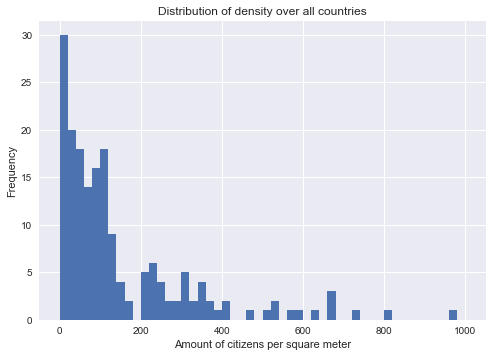

In [13]:
# Create a histogram of the density distribution (Amount of citizens per square meter)
df_countryinfo['density'].hist(bins = 50, range = (0, 1000))
plt.title("Distribution of density over all countries")
plt.xlabel('Amount of citizens per square meter')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

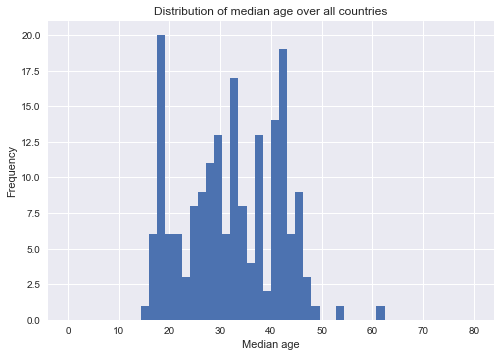

In [14]:
# Create a histogram of the median age distribution
df_countryinfo['medianage'].hist(bins = 50, range = (0, 80))
plt.title("Distribution of median age over all countries")
plt.xlabel('Median age')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

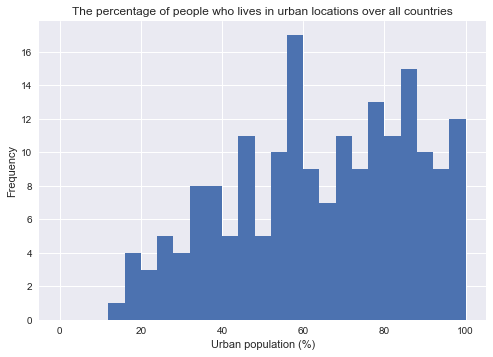

In [15]:
# Create a histogram of the percentage of people who lives in urban locations
df_countryinfo['urbanpop'].hist(bins = 25, range = (0, 100))
plt.title("The percentage of people who lives in urban locations over all countries")
plt.xlabel('Urban population (%)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

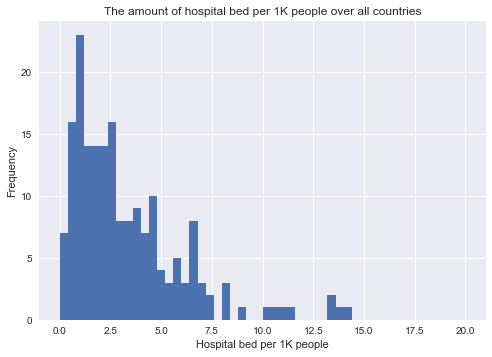

In [16]:
# Create a histogram of the amount of hospital bed per 1K people
df_countryinfo['hospibed'].hist(bins = 50, range = (0, 20))
plt.title("The amount of hospital bed per 1K people over all countries")
plt.xlabel('Hospital bed per 1K people')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

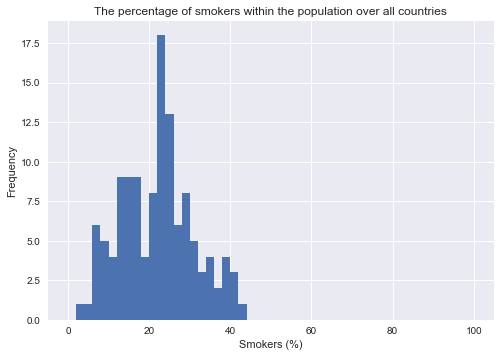

In [17]:
# Create a histogram of the % of smokers within the population.
df_countryinfo['smokers'].hist(bins = 50, range = (0, 100))
plt.title("The percentage of smokers within the population over all countries")
plt.xlabel('Smokers (%)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

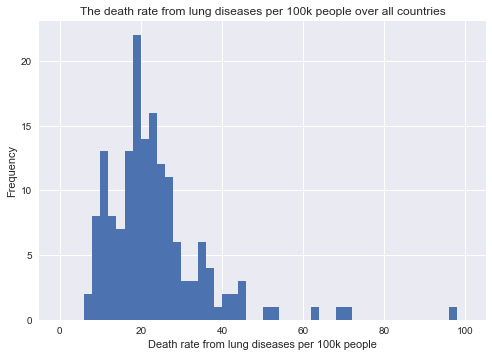

In [18]:
# Create a histogram of the death rate from lung diseases per 100k people
df_countryinfo['lung'].hist(bins = 50, range = (0, 100))
plt.title("The death rate from lung diseases per 100k people over all countries")
plt.xlabel('Death rate from lung diseases per 100k people')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

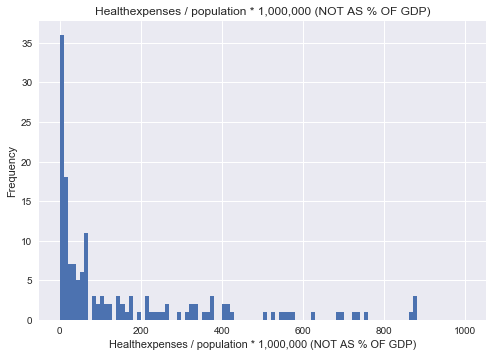

In [19]:
# Create a histogram of healthexp / population * 1,000,000 (NOT AS % OF GDP)
# healthexp: Health expenses in International USD (Inflation taken in count)
df_countryinfo['healthperpop'].hist(bins = 100, range = (0, 1000))
plt.title("Healthexpenses / population * 1,000,000 (NOT AS % OF GDP)")
plt.xlabel('Healthexpenses / population * 1,000,000 (NOT AS % OF GDP)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

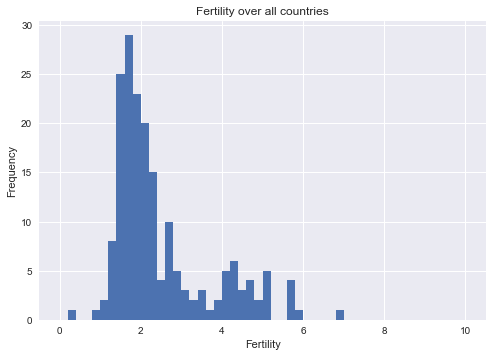

In [20]:
# Create a histogram of the fertility
df_countryinfo['fertility'].hist(bins = 50, range = (0, 10))
plt.title("Fertility over all countries")
plt.xlabel('Fertility')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

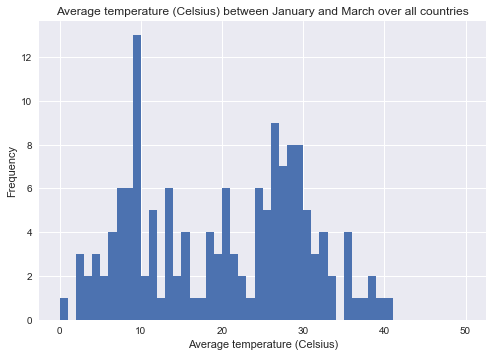

In [21]:
# Create a histogram of the average temperature (Celsius) between January and March 
df_countryinfo['avgtemp'].hist(bins = 50, range = (0, 50))
plt.title("Average temperature (Celsius) between January and March over all countries")
plt.xlabel('Average temperature (Celsius)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

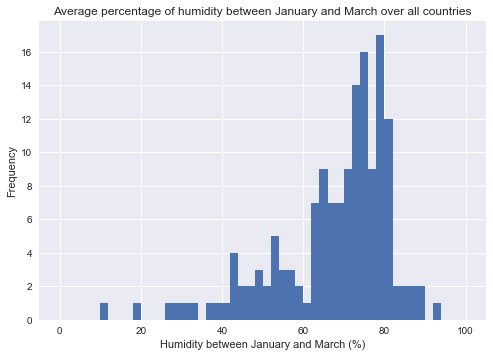

In [22]:
# Create a histogram of the average percentage of humidity between January and March
df_countryinfo['avghumidity'].hist(bins = 50, range = (0, 100))
plt.title("Average percentage of humidity between January and March over all countries")
plt.xlabel('Humidity between January and March (%)')
plt.ylabel('Frequency')

It shall be checked later on whether the plotted measures have an effect on the intensity of the outbreaks. Furthermore, the table contains other information like dates when specifc measures against the disease have been started, e.g. school closure policy. These dates might help to analyse the containment effects.

## 3. Data preparation
### Timeseries dataset
The timeseries set contains columns for each day from January 22, 2020 to show the number of cases for each country/region (as plotted above). Since the timeseries shall later on be combined with the country information dataset, it is necessary to ensure that the timeseries can be assigned to the correct country information. Thus, some preparation is required. As shown in the last chapter, some Countries/Regions are subdivided into different Provinces/States. Since the corresponding information does not exist in the country information set, the different Provinces/States are first combined by summing up the case numbers with the following function.

In [23]:
def combine_in_country(df, name):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    name - string with a Country/Region for which the rows shall be combined
    
    Description:
    The function combines rows which belong to the same Country/Region by summing up the case numbers.
    For Lat and Long the mean is used. Note: This might be not the best approach in case of oversea provinces.
    '''
    
    # Copy input dataframe into output dataframe
    df_output = df.copy()
    
    # Create a new series
    new_row = pd.Series()
    
    # Assign a field for Country/Region
    new_row['Country/Region'] = name
    
    # Iterate over all rows
    row_initialized = False
    counter = 0
    for index, row in df_output.iterrows():
        if name == row['Country/Region']:
            
            # If the Country/Region in a row fits to name, the value of all columns are added to the new series
            for col_name, col_data in df_output.iteritems():
                if col_name != 'Province/State' and col_name != 'Country/Region':
                    
                    # Initially, each value of the new series is initialized
                    if not(row_initialized):
                        new_row.at[col_name] = 0
                        
                    # Sum up
                    new_row.at[col_name] = new_row.at[col_name] + df_output.at[index, col_name]
                    
            row_initialized = True # Make sure to initialize only once
            counter = counter + 1 # Count up every time the name==Country/Region
            
    # Take the mean of lat and long values. Note: This might be not the best approach in case of oversea provinces.
    new_row.at['Lat'] = new_row.at['Lat'] / counter
    new_row.at['Long'] = new_row.at['Long'] / counter
            
    # Add the new series to the output dataframe 
    df_output = df_output.append(new_row, ignore_index = True)

    return df_output # Return output dataframe

In [24]:
# Combine all Provinces/States by using the combine_in_country function
df_timeseries_combined = df_timeseries.copy()
df_timeseries_combined = combine_in_country(df_timeseries_combined, 'China')
df_timeseries_combined = combine_in_country(df_timeseries_combined, 'Canada')
df_timeseries_combined = combine_in_country(df_timeseries_combined, 'France')
df_timeseries_combined = combine_in_country(df_timeseries_combined, 'United Kingdom')
df_timeseries_combined = combine_in_country(df_timeseries_combined, 'Australia')
df_timeseries_combined = combine_in_country(df_timeseries_combined, 'Netherlands')
df_timeseries_combined = combine_in_country(df_timeseries_combined, 'Denmark')

# Replace nans by empty entries
df_timeseries_combined['Province/State'].fillna("", inplace=True)

# Remove rows which are no longer required (since provinces/states have been combined in new rows)
df_timeseries_combined = df_timeseries_combined[df_timeseries_combined['Province/State'] == '']

# Sort according to Country/Region
df_timeseries_combined = df_timeseries_combined.sort_values(by = 'Country/Region')

# Drop further duplicates (countries without provinces which are already listed individually in original table)
df_timeseries_combined = df_timeseries_combined.drop([94]) # Denmark
df_timeseries_combined = df_timeseries_combined.drop([116]) # France
df_timeseries_combined = df_timeseries_combined.drop([169]) # Netherlands
df_timeseries_combined = df_timeseries_combined.drop([223]) # United Kingdom

# Reset the index (so that there are no gaps due to removed rows)
df_timeseries_combined=df_timeseries_combined.reset_index(drop=True)

In [25]:
df_timeseries_combined.head(200)

Province/State                    Country/Region        Lat        Long  \
0                                        Afghanistan  33.000000   65.000000   
1                                            Albania  41.153300   20.168300   
2                                            Algeria  28.033900    1.659600   
3                                            Andorra  42.506300    1.521800   
4                                             Angola -11.202700   17.873900   
5                                Antigua and Barbuda  17.060800  -61.796400   
6                                          Argentina -38.416100  -63.616700   
7                                            Armenia  40.069100   45.038200   
8                                          Australia -31.996188  141.232788   
9                                            Austria  47.516200   14.550100   
10                                        Azerbaijan  40.143100   47.576900   
11                                           Bahamas  25.034300  -77.396300   
12                                           Bahrain  26.027500   50.550000   
13                                        Bangladesh  23.685000   90.356300   
14                                          Barbados  13.193900  -59.543200   
15                                           Belarus  53.709800   27.953400   
16                                           Belgium  50.833300    4.000000   
17                                            Belize  13.193900  -59.543200   
18                                             Benin   9.307700    2.315800   
19                                            Bhutan  27.514200   90.433600   
20                                           Bolivia -16.290200  -63.588700   
21                            Bosnia and Herzegovina  43.915900   17.679100   
22                                          Botswana -22.328500   24.684900   
23                                            Brazil -14.235000  -51.925300   
24                                            Brunei   4.535300  114.727700   
25                                          Bulgaria  42.733900   25.485800   
26                                      Burkina Faso  12.238300   -1.561600   
27                                             Burma  21.916200   95.956000   
28                                           Burundi  -3.373100   29.918900   
29                                        Cabo Verde  16.538800  -23.041800   
30                                          Cambodia  11.550000  104.916700   
31                                          Cameroon   3.848000   11.502100   
32                                            Canada  44.784047  -82.508593   
33                          Central African Republic   6.611100   20.939400   
34                                              Chad  15.454200   18.732200   
35                                             Chile -35.675100  -71.543000   
36                                             China  32.828385  111.649082   
37                                          Colombia   4.570900  -74.297300   
38                                           Comoros -11.645500   43.333300   
39                               Congo (Brazzaville)  -4.038300   21.758700   
40                                  Congo (Kinshasa)  -4.038300   21.758700   
41                                        Costa Rica   9.748900  -83.753400   
42                                     Cote d'Ivoire   7.540000   -5.547100   
43                                           Croatia  45.100000   15.200000   
44                                              Cuba  22.000000  -80.000000   
45                                            Cyprus  35.126400   33.429900   
46                                           Czechia  49.817500   15.473000   
47                                           Denmark  63.287800  -13.338100   
48                                  Diamond Princess   0.000000    0.000000   
49                                          Djibouti  

In [26]:
df_timeseries_combined.shape[0]

187

#### Create normalized timeseries dataset to overlay the rates of increase for all countries

The start dates of the outbreaks in the different countries/regions were very different. In order to compare them, the first step is to normalize everything to a "day 1" which is the day when a specific number of cases has been detected in each individual country. After that it would be possible to compare the overlaying curves.

In [27]:
def normalize_timeseries(df, outbreak_threshold):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    outbreak_threshold - int value describing at which minimal number of cases the series starts ("day 1").
                         The idea is that smaller outbreaks which are under control are not counted.
    
    OUTPUT:
    df - pandas dataframe with normalized timeseries
    
    Description:
    The input timeseries are normalized to a "day 1"
    '''

    # Create a new dataframe and copy the first 4 columns of the input set
    df_output = pd.DataFrame()
    df_output['Province/State'] = df['Province/State']
    df_output['Country/Region'] = df['Country/Region']
    df_output['Lat'] = df['Lat']
    df_output['Long'] = df['Long']
    df_output['Infections'] = 0 # New column which is later on used for sorting
    df_output['Outbreak_Start'] = '' # New column which is used to store the date of a detected outbreak (which exceeds threshold)
    
    # Iterate over all rows
    for index, row in df.iterrows():
    
        # Iterate over all columns
        counter = 0
        new_column = 1 # Counter for the columns in output dataframe
        for col_name, col_data in df.iteritems():
            counter = counter + 1 # Count the columns
            if counter > 4: # The timeseries start from column 5
                if df.at[index, col_name] > outbreak_threshold or new_column > 1: # If threshold is exceeded or if timeseries has already started
                    # Store the date of the outbreak by using the name of the original columns in which the case threshold has been exceeded
                    if new_column == 1:
                        df_output.at[index, 'Outbreak_Start'] = col_name       
                    df_output.at[index, str(new_column)] = df.at[index, col_name] # Copy case number in new column in output
                    new_column = new_column + 1 # Count up column
                    
        # Add the number of infections as an extra information
        df_output.at[index, 'Infections'] = df.iloc[index, -1]
                    
    return df_output # Return output dataframe

In [28]:
# Normalize timeseries dataset so that the outbreaks in all countries start at "day 1"
df_norm = normalize_timeseries(df_timeseries_combined, outbreak_threshold)
df_norm.head()

Province/State Country/Region      Lat     Long  Infections Outbreak_Start  \
0                   Afghanistan  33.0000  65.0000        2335        3/14/20   
1                       Albania  41.1533  20.1683         782        3/11/20   
2                       Algeria  28.0339   1.6596        4154         3/4/20   
3                       Andorra  42.5063   1.5218         745        3/17/20   
4                        Angola -11.2027  17.8739          30         4/5/20   

      1     2     3     4     5      6      7      8      9     10     11  \
0  11.0  16.0  21.0  22.0  22.0   22.0   24.0   24.0   40.0   40.0   74.0   
1  12.0  23.0  33.0  38.0  42.0   51.0   55.0   59.0   64.0   70.0   76.0   
2  12.0  12.0  17.0  17.0  19.0   20.0   20.0   20.0   24.0   26.0   37.0   
3  39.0  39.0  53.0  75.0  88.0  113.0  133.0  164.0  188.0  224.0  267.0   
4  14.0  16.0  17.0  19.0  19.0   19.0   19.0   19.0   19.0   19.0   19.0   

      12     13     14     15     16     17     18     19     20     21  \
0   84.0   94.0  110.0  110.0  120.0  170.0  174.0  237.0  273.0  281.0   
1   89.0  104.0  123.0  146.0  174.0  186.0  197.0  212.0  223.0  243.0   
2   48.0   54.0   60.0   74.0   87.0   90.0  139.0  201.0  230.0  264.0   
3  308.0  334.0  370.0  376.0  390.0  428.0  439.0  466.0  501.0  525.0   
4   19.0   19.0   24.0   24.0   24.0   24.0   25.0   25.0   25.0   25.0   

      22     23     24     25     26     27     28     29     30      31  \
0  299.0  349.0  367.0  423.0  444.0  484.0  521.0  555.0  607.0   665.0   
1  259.0  277.0  304.0  333.0  361.0  377.0  383.0  400.0  409.0   416.0   
2  302.0  367.0  409.0  454.0  511.0  584.0  716.0  847.0  986.0  1171.0   
3  545.0  564.0  583.0  601.0  601.0  638.0  646.0  659.0  673.0   673.0   
4   26.0   27.0   27.0   27.0   27.0   30.0    NaN    NaN    NaN     NaN   

       32      33      34      35      36      37      38      39      40  \
0   714.0   784.0   840.0   906.0   933.0   996.0  1026.0  1092.0  1176.0   
1   433.0   446.0   467.0   475.0   494.0   518.0   539.0   548.0   562.0   
2  1251.0  1320.0  1423.0  1468.0  1572.0  1666.0  1761.0  1825.0  1914.0   
3   696.0   704.0   713.0   717.0   717.0   723.0   723.0   731.0   738.0   
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

       41      42      43      44      45      46      47      48      49  \
0  1279.0  1351.0  1463.0  1531.0  1703.0  1828.0  1939.0  2171.0  2335.0   
1   584.0   609.0   634.0   663.0   678.0   712.0   726.0   736.0   750.0   
2  1983.0  2070.0  2160.0  2268.0  2418.0  2534.0  2629.0  2718.0  2811.0   
3   738.0   743.0   743.0   743.0   745.0   745.0     NaN     NaN     NaN   
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

       50      51      52      53      54      55      56      57      58  \
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1   766.0   773.0   782.0     NaN     NaN     NaN     NaN     NaN     NaN   
2  2910.0  3007.0  3127.0  3256.0  3382.0  3517.0  3649.0  3848.0  4006.0   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

       59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  \
0     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2  4154.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

   77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN N

Now all timeseries start on the same day (column "1"). In the following, the countries with the highest number of cases at the end of the timeseries are visualized by the previously defined function. Before doing this, another function is required to sort according to the number of infections which is no longer possible out-of-the-box (last column of timeseries cannot be used).

In [29]:
def sort_according_to_number_of_infections(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries of number of infections
    
    OUTPUT:
    df - pandas dataframe in which the rows are sorted according to the number of infections
    
    Description:
    Sorts the rows in a descending manner according the number of infections
    '''

    # Create output dataframe
    df_output = df.copy()
    
    # If the columns with the number of infections is already there (create by normalize_timeseries), sort according to it.
    if 'Infections' in df:
        # Sort according to number of infections
        df_output = df_output.sort_values(by = 'Infections', ascending = False)
        
    # If the column does not exist, create it temporarily and sort accoring to it.
    else:
        # Iterate over all rows
        for index, row in df_output.iterrows():
    
            # Iterate over all columns
            values_found = False 
            infections = 0
            for col_name, col_data in df_output.iteritems():
                if col_name == '1' or values_found:
                    if not(values_found):
                        values_found = True
                    if df_output.at[index, col_name] > infections:
                        infections = df_output.at[index, col_name] # If there is a higher number of cases, overwrite old value
                
            df_output.at[index, 'Infections'] = infections
    
        # Sort according to number of infections
        df_output = df_output.sort_values(by = 'Infections', ascending = False)
    
        # Delete helper column after sorting
        del df_output['Infections']
        
    return df_output

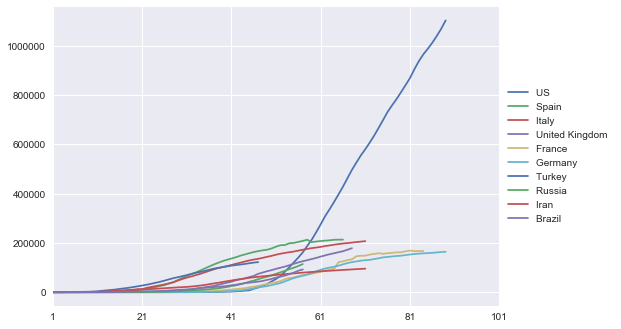

In [30]:
# Visualize the 10 countries with the highest number of infections (sorted ascendingly and select top 10)
visualize_timeseries(sort_according_to_number_of_infections(df_norm).head(10), False)

In order to compare the different curves, the idea is to find a measure describing the exponential growth which obviously starts directly after a detected outbreak. However, after some specific timepoint each curve shows a trend to a more linear growth. This might be the result of governmental measures, attitude changes of the population, and possible saturation effects of local outbreaks. A visualization with a logarithmic scale of the y-axis shows this much better.

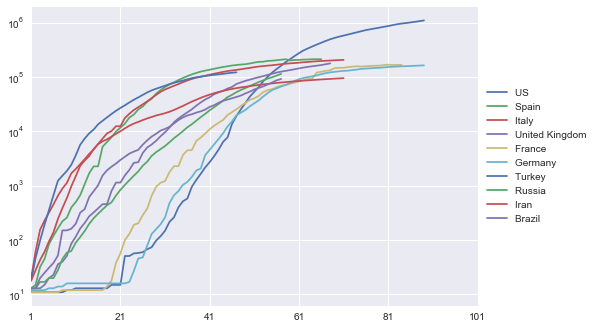

In [31]:
# Visualize the 10 countries with the highest number of infections (sorted ascendingly and select top 10) on a log-scale
visualize_timeseries(sort_according_to_number_of_infections(df_norm).head(10), True)

The curves above show some noise which is always challenging when modelling data. Thus, the data will be applied to a noise filter. The function for this filter is defined in the next step. Here a Savitzky-Golay filter is used which bases on a polynomial regression. It is less biased than a sliding window filter using the mean.

In [32]:
def savitzky_golay_filter(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which which is the filtered input dataframe
    
    Description:
    A Savitzky-Golay filter is used for the filtering
    '''

    # Create output dataframe
    df_output = df.copy()
    
    # Iterate over all rows
    for index, row in df_output.iterrows():
        
        # Create a list which is used to call the savgol_filter function
        value_list = []
        
        # Iterate over all columns
        values_found = False
        for col_name, col_data in df_output.iteritems():
            if (col_name == '1' or values_found) and not(np.isnan(df_output.at[index, col_name])):
                if not(values_found):
                    values_found = True
                value_list.append(df_output.at[index, col_name]) # Add value to list
        
        # Call the savgol_filter function
        if len(value_list) >= 5:
            value_list=savgol_filter(value_list, 5, 2)

        # Create an iterator to iterate through the savgol_filter output
        value_liste_iterator = iter(value_list)
        
        # Iterate over all columns
        values_found = False
        for col_name, col_data in df_output.iteritems():
            if (col_name == '1' or values_found) and not(np.isnan(df_output.at[index, col_name])):
                if not(values_found):
                    values_found = True
                df_output.at[index, col_name] = next(value_liste_iterator) # Write output in output dataframe
                
    return df_output
    

In [33]:
# Create a dataframe as a filtered version of the normalized dataframe
df_norm_filtered = savitzky_golay_filter(df_norm)

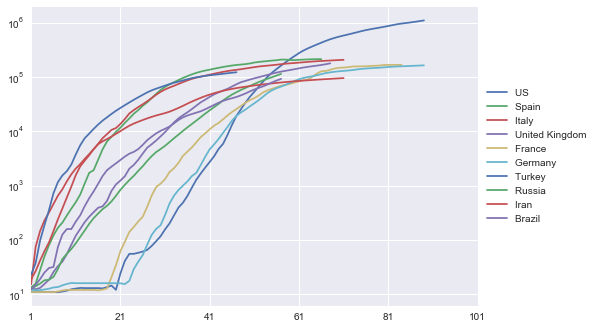

In [34]:
# Visualize in filtered data the 10 countries with the highest number of infections (sorted ascendingly and select top 10) on a log-scale
visualize_timeseries(sort_according_to_number_of_infections(df_norm_filtered).head(10), True)

### Country information dataset
Now, the countryinfo dataset is prepared. Also here it is required to remove rows to make it compatible with the timeseries dataset. In the first step, all US states are removed, since for these ones no data exist in the series, since in contains only a combined row for the US (from the beginning, not just after preprocessing).

In [35]:
# Copy the original dataset
df_countryinfo_reduced = df_countryinfo.copy()

# Replace nans by empty entries
df_countryinfo_reduced['region'].fillna("", inplace=True)

# Remove rows which are no longer required (since provinces/states have been combined in new rows)
df_countryinfo_reduced = df_countryinfo_reduced[df_countryinfo_reduced['region'] == '']

# Sort according to country
df_countryinfo_reduced = df_countryinfo_reduced.sort_values(by = 'country')

# Reset the index (so that there are no gaps due to removed rows)
df_countryinfo_reduced = df_countryinfo_reduced.reset_index(drop = True)

In the next step, the columns that are not automatically interpreted as numbers are converted.

In [36]:
# Replace the comma-delimiter which lead to a wrong interpretation of the columns 
df_countryinfo_reduced['pop'] = df_countryinfo_reduced['pop'].str.replace(',', '')
df_countryinfo_reduced['gdp2019'] = df_countryinfo_reduced['gdp2019'].str.replace(',', '')
df_countryinfo_reduced['healthexp'] = df_countryinfo_reduced['healthexp'].str.replace(',', '')

In [37]:
# Convert cells into numbers
df_countryinfo_reduced['pop'] = df_countryinfo_reduced['pop'].astype('float64')
df_countryinfo_reduced['gdp2019'] = df_countryinfo_reduced['gdp2019'].astype('float64')
df_countryinfo_reduced['healthexp'] = df_countryinfo_reduced['healthexp'].astype('float64')

In [38]:
# Adapt the name of the country column
df_countryinfo_reduced.rename(columns = {'country': 'Country'}, inplace=True)

In [39]:
df_countryinfo_reduced.head(200)

region                           Country alpha3code alpha2code  \
0                                Afghanistan        AFG         AF   
1                                    Albania        ALB         AL   
2                                    Algeria        DZA         DZ   
3                                    Andorra        AND         AD   
4                        Antigua and Barbuda        ATG         AG   
5                                  Argentina        ARG         AR   
6                                    Armenia        ARM         AM   
7                                  Australia        AUS         AU   
8                                    Austria        AUT         AT   
9                                 Azerbaijan        AZE         AZ   
10                                   Bahamas        BHS         BS   
11                                   Bahrain        BHR         BH   
12                                Bangladesh        BGD         BD   
13                                  Barbados        BRB         BB   
14                                   Belarus        BLR         BY   
15                                   Belgium        BEL         BE   
16                                    Belize        BLZ         BZ   
17                                     Benin        BEN         BJ   
18                                    Bhutan        BTN         BT   
19                                   Bolivia        BOL         BO   
20                    Bosnia and Herzegovina        BIH         BA   
21                                    Brazil        BRA         BR   
22                                    Brunei        BRN         BN   
23                                  Bulgaria        BGR         BG   
24                              Burkina Faso        BFA         BF   
25                                Cabo Verde        CPV         CV   
26                                  Cambodia        KHM         KH   
27                                  Cameroon        CMR         CM   
28                                    Canada        CAN         CA   
29                  Central African Republic        CAF         CF   
30                                      Chad        TDC         TD   
31                                     Chile        CHL         CN   
32                                     China        CHN         CN   
33                                  Colombia        COL         CO   
34                       Congo (Brazzaville)        COG         CG   
35                          Congo (Kinshasa)        COG         CG   
36                                Costa Rica        CRI         CR   
37                             Cote d'Ivoire        CIV         CI   
38                                   Croatia        HRV         HR   
39                                      Cuba        CUB         CU   
40                                    Cyprus        CYP         CY   
41                                   Czechia        CZE         CZ   
42                                   Denmark        DNK         DK   
43                          Diamond Princess        NaN        NaN   
44                                  Djibouti        DJI         DJ   
45                                  Dominica        DMA         DM   
46                        Dominican Republic        DOM         DO   
47                                   Ecuador        ECU         EC   
48                                     Egypt        EGY         EG   
49                               El Salvador        SLV         SV   
50                         Equatorial Guinea        GNQ         GQ   
51                                   Eritrea        ERI         ER   
52                                   Estonia        EST         EE   
53                                  Eswatini        SWZ         SZ   
54                                  Ethiopia        ETH         ET   
55                                      Fiji        FJI         FJ   
56            

### Merge datasets

In [40]:
# Change column name before merging (merged dataframes neend an identical column)
df_norm_filtered.rename(columns = {'Country/Region': 'Country'}, inplace = True)

In [41]:
# Do the merge step
df_all = pd.merge(df_countryinfo_reduced, df_norm_filtered , on = 'Country', how = 'inner')

In [42]:
# Remove unused columns for region and Province/State
del df_all['region']
del df_all['Province/State']

# Remove other unused columns (e.g. since they contain too many nans or they describe outdated case number information taken from the country information dataframe)
del df_all['alpha3code']
del df_all['alpha2code']
del df_all['tests']
del df_all['testpop']
del df_all['gatheringlimit']
del df_all['firstcase']
del df_all['totalcases']
del df_all['active30']
del df_all['active31']
del df_all['active1']
del df_all['active2']
del df_all['active3']
del df_all['newcases30']
del df_all['newcases31']
del df_all['newcases1']
del df_all['newcases2']
del df_all['newcases3']
del df_all['deaths']
del df_all['newdeaths30']
del df_all['newdeaths31']
del df_all['newdeaths1']
del df_all['newdeaths2']
del df_all['newdeaths3']
del df_all['recovered']
del df_all['critical30']
del df_all['critical31']
del df_all['critical1']
del df_all['critical2']
del df_all['critical3']
del df_all['casediv1m']
del df_all['deathdiv1m']

In [43]:
# Show number of nans per column again (after preprocessing steps)
df_all.isna().sum()

Country             0
pop                 0
density             0
medianage           0
urbanpop            0
quarantine        148
schools           146
publicplace       158
gathering         160
nonessential      168
hospibed            0
smokers            50
sex0                2
sex14               2
sex25               2
sex54               2
sex64               2
sex65plus           2
sexratio            3
lung               10
femalelung         10
malelung           10
gdp2019             1
healthexp           3
healthperpop        2
fertility           1
avgtemp            29
avghumidity        29
Lat                 0
Long                0
Infections          0
Outbreak_Start      0
1                   3
2                   3
3                   5
4                   5
5                   5
6                   5
7                   5
8                   5
9                   5
10                  6
11                  6
12                  6
13                  6
14        

As checked above, there are an average number of nans in the columns for average temperature and average humidity. Since these columns seem to be interesting to make predictions on the disease, the missing values are imputed by the mean values of the remaining cells.

In [44]:
# Fill the nans in the average temperature and average humidity column by the mean
df_all['avgtemp'].fillna((df_all['avgtemp'].mean()), inplace=True)
df_all['avghumidity'].fillna((df_all['avghumidity'].mean()), inplace=True)

In [45]:
df_all.head(200)

Country           pop  density  medianage  \
0                         Afghanistan  3.892835e+07     60.0       18.0   
1                             Albania  2.877797e+06    105.0       36.0   
2                             Algeria  4.385104e+07     18.0       29.0   
3                             Andorra  7.726500e+04    164.0       45.0   
4                 Antigua and Barbuda  9.792900e+04    223.0       34.0   
5                           Argentina  4.519577e+07     17.0       32.0   
6                             Armenia  2.963243e+06    104.0       35.0   
7                           Australia  2.549988e+07      3.0       38.0   
8                             Austria  9.006398e+06    109.0       43.0   
9                          Azerbaijan  1.013918e+07    123.0       32.0   
10                            Bahamas  3.932440e+05     39.0       32.0   
11                            Bahrain  1.701575e+06   2239.0       32.0   
12                         Bangladesh  1.646894e+08   1265.0       28.0   
13                           Barbados  2.873750e+05    668.0       40.0   
14                            Belarus  9.449323e+06     47.0       40.0   
15                            Belgium  1.158962e+07    383.0       42.0   
16                             Belize  3.976280e+05     17.0       24.0   
17                              Benin  1.212320e+07    108.0       19.0   
18                             Bhutan  7.716080e+05     20.0       28.0   
19                            Bolivia  1.167302e+07     11.0       26.0   
20             Bosnia and Herzegovina  3.280819e+06     64.0       43.0   
21                             Brazil  2.125594e+08     25.0       33.0   
22                             Brunei  4.374790e+05     83.0       32.0   
23                           Bulgaria  6.948445e+06     64.0       45.0   
24                       Burkina Faso  2.090327e+07     76.0       18.0   
25                         Cabo Verde  5.544410e+05    138.0       27.6   
26                           Cambodia  1.671896e+07     95.0       26.0   
27                           Cameroon  2.654586e+07     56.0       19.0   
28                             Canada  3.774215e+07      4.0       41.0   
29           Central African Republic  3.774215e+07      8.0       18.0   
30                               Chad  1.630270e+07     13.0       16.6   
31                              Chile  1.911620e+07     26.0       35.0   
32                              China  1.439324e+09    153.0       38.0   
33                           Colombia  5.088289e+07     46.0       31.0   
34                Congo (Brazzaville)  5.518087e+06     16.0       19.0   
35                   Congo (Kinshasa)  8.956140e+07     40.0       17.0   
36                         Costa Rica  5.094118e+06    100.0       33.0   
37                      Cote d'Ivoire  2.637827e+07     83.0       19.0   
38                            Croatia  4.105267e+06     73.0       44.0   
39                               Cuba  1.132662e+07    106.0       42.0   
40                             Cyprus  1.207359e+06    131.0       37.0   
41                            Czechia  1.070898e+07    139.0       43.0   
42                            Denmark  5.792202e+06    137.0       42.0   
43                   Diamond Princess  3.500000e+03     25.0       62.0   
44                           Djibouti  9.880000e+05     43.0       27.0   
45                           Dominica  7.198600e+04     96.0       33.5   
46                 Dominican Republic  1.084791e+07    225.0       28.0   
47                            Ecuador  1.764305e+07     71.0       28.0   
48                              Egypt  1.023344e+08    103.0       25.0   
49                        El Salvador  6.486205e+06    313.0       27.6   
50                  Equatorial Guinea  1.402985e+06     50.0       22.0   
51                            Eritrea  3.546421e+06     35.0       19.2   
52                            Estonia  1.326535e+06    

Please note that some countries got lost since they to do not appear in both datasets. However, this is accepted since the analysis has a more general focus.

In the last data preprocessing step, the dates in the measure columns are replaced by integer values. The idea behind is that a machine learning method can then easier use the single measures as features to predict the overall effect of measures. 

In [46]:
def calc_diff_between_outbreak_and_measure(df, measure, penality):
    '''
    INPUT:
    df_norm - pandas dataframe with the complete data set
    measure - name of the column that should be converted into a difference of days
    penality - penality value if there is just a nan
    
    Description:
    Converts the date at which a measure has been started into the difference of days 
    between the outbreak in the specific country (corresponding to the row) and the date the mesure has been started.
    If the measure does not exist (nan), a penalty value is added.
    '''

    # Create an output dataset
    df_output = df.copy()
    
    df_output[measure].fillna("", inplace = True)
    
    # Iterate over all rows
    for index, row in df_all.iterrows():
        # If there is a NaN (no measure took place) or there was no significant outbreak start
        # which will later be not considered, add penality costs
        if df_output.at[index, measure] == '' or df_output.at[index, 'Outbreak_Start'] == '':
            df_output.at[index, measure] = int(penality)
        else:
            # Get the string of outbreak start and convert it to the date format
            date_outbreak_string = str(df_output.at[index, 'Outbreak_Start']).split("/")
            date_outbreak = date(int(date_outbreak_string[2]) + 2000, int(date_outbreak_string[0]), int(date_outbreak_string[1]))

            # Get the string of measure start and convert it to the date format
            date_measure_string = str(df_output.at[index, measure]).split("/")
            date_measure = date(int(date_measure_string[2]), int(date_measure_string[0]), int(date_measure_string[1]))        

            # Calculate the days between outbreak start and start of the measure and add it to the output dataframe
            df_output.at[index, measure] = (date_measure-date_outbreak).days

    return df_output # Return output dataframe


In [47]:
# Use calc_diff_between_outbreak_and_measure function to calculate days between outbreak start and start of measure
df_all=calc_diff_between_outbreak_and_measure(df_all, 'quarantine', penality)
df_all=calc_diff_between_outbreak_and_measure(df_all, 'schools', penality)
df_all=calc_diff_between_outbreak_and_measure(df_all, 'publicplace', penality)
df_all=calc_diff_between_outbreak_and_measure(df_all, 'gathering', penality)
df_all=calc_diff_between_outbreak_and_measure(df_all, 'nonessential', penality)

In [48]:
df_all.head(10)

Country         pop  density  medianage  urbanpop quarantine  \
0          Afghanistan  38928346.0     60.0       18.0      25.0         50   
1              Albania   2877797.0    105.0       36.0      63.0         50   
2              Algeria  43851044.0     18.0       29.0      73.0         50   
3              Andorra     77265.0    164.0       45.0      88.0         50   
4  Antigua and Barbuda     97929.0    223.0       34.0      26.0         50   
5            Argentina  45195774.0     17.0       32.0      93.0         12   
6              Armenia   2963243.0    104.0       35.0      63.0         50   
7            Australia  25499884.0      3.0       38.0      86.0         50   
8              Austria   9006398.0    109.0       43.0      57.0         15   
9           Azerbaijan  10139177.0    123.0       32.0      56.0         50   

  schools publicplace gathering nonessential  hospibed  smokers  sex0  sex14  \
0      50          50        50           50       0.5      NaN  1.05   1.03   
1      50          50        50           50       2.9    29.40  1.08   1.11   
2      50          50        50           50       1.9      NaN  1.05   1.05   
3      50          50        50           50       2.5    32.50  1.07   1.05   
4      50          50        50           50       3.8      NaN  1.05   1.03   
5      50          50        50           50       5.0    23.95  1.05   1.06   
6      50          50        50           50       4.2    26.90  1.13   1.14   
7      50          51        57           50       3.8    14.90  1.06   1.06   
8      50          50        50           50       7.6    35.15  1.05   1.05   
9      50          50        50           50       4.7    23.45  1.11   1.15   

   sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  malelung  \
0   1.03   1.03   0.97       0.85      1.03  37.62       36.31     39.33   
1   1.09   0.93   0.95       0.87      0.98  11.67        7.02     17.04   
2   1.05   1.03   1.01       0.89      1.03   8.77        5.03     12.81   
3   1.08   1.05   1.15       1.02      1.06    NaN         NaN       NaN   
4   0.99   0.84   0.82       0.76      0.90  11.76        7.67     18.78   
5   1.05   1.00   0.94       0.71      0.98  29.27       20.16     42.59   
6   1.06   0.93   0.84       0.67      0.94  23.86       16.17     35.99   
7   1.09   0.99   0.93       0.86      0.99  18.79       15.90     22.16   
8   1.04   1.00   0.98       0.76      0.96  17.02       13.02     22.14   
9   1.09   0.96   0.86       0.62      0.98  20.61       14.07     29.32   

     gdp2019  healthexp  healthperpop  fertility    avgtemp  avghumidity  \
0    18734.0      184.0      4.726633       5.12   6.216667    56.933333   
1    15418.0      774.0    268.955733       1.51  13.950000    69.900000   
2   172781.0     1031.0     23.511413       2.70  19.566667    61.716667   
3    91527.0     5949.0  76994.758300       1.40   7.383333    75.233333   
4     1688.0     1105.0  11283.685120       2.00  19.029371    67.222844   
5   445469.0     1390.0     30.755088       2.26  32.816667    43.616667   
6    13444.0      883.0    297.984337       1.64   7.100000    58.500000   
7  1376255.0     4492.0    176.157664       1.77  25.783333    64.233333   
8   447718.0     5138.0    570.483339       1.47   9.466667    65.350000   
9    47171.0     1191.0    117.465155       1.89  10.166667    68.083333   

         Lat        Long  Infections Outbreak_Start          1          2  \
0  33.000000   65.000000        2335        3/14/20  10.800000  16.600000   
1  41.153300   20.168300         782        3/11/20  11.885714  23.457143   
2  28.033900    1.659600        4154         3/4/20  11.457143  13.571429   
3  42.506300    1.521800         745        3/17/20  36.857143  42.971429   
4  17.060800  -61.796400          25         4/3/20  15.342857  14.428571   
5 -38.416100  -63.616700        4532         3/8/20  11.171429  13.914286   
6  40.069100   45.038200        2148        3/14/20

## 4. Modelling and Evaluation

### Calculation of the derivative

An important point to understand differences in the intensity of exponential growth of the curves from different countries is to find out at which timepoint the exponential growth ends. An idea for this would be to take the timepoint at which the steepest increase takes place. After this point, the outbreak obviously looses speed. Mathematically spoken, this point is the second derivative of the function describing the cumulative number of cases.

A derivative of a function describes the slope of a function. Applied to the cumulative growth of the Corona cases, the first derivative is simply the number of new detected cases per day. This is done in the following function. If the function is applied twice, the second derivative is calculated.

In [49]:
def derivative(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which represents a derivative of the input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x - 1 from the input array.
    '''

    # Create output dataframe
    df_output = df.copy()
    
    # Iterate over all rows
    for index, row in df.iterrows():
    
        values_found = False # False as long as the values of the timeseries have not been found
        increase = 0
        last_col_name = 0
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if col_name == '1' or values_found:
                if not(values_found):
                    values_found = True
                if last_col_name != 0:
                    # Caluculate the difference of the current column and the last one (at current row)
                    # The difference is the slope and is assigned to the output dataframe
                    df_output.at[index, col_name] = df.at[index, col_name]-df.at[index, last_col_name]
                    last_col_name = col_name
                else:
                    df_output.at[index, col_name] = 0
                    last_col_name = col_name  
                    
    return df_output #  Return output dataframe

In [50]:
# Calculate the 1st derivative
df_all_derivative = derivative(df_all)
df_all_derivative.head()

Country         pop  density  medianage  urbanpop quarantine  \
0          Afghanistan  38928346.0     60.0       18.0      25.0         50   
1              Albania   2877797.0    105.0       36.0      63.0         50   
2              Algeria  43851044.0     18.0       29.0      73.0         50   
3              Andorra     77265.0    164.0       45.0      88.0         50   
4  Antigua and Barbuda     97929.0    223.0       34.0      26.0         50   

  schools publicplace gathering nonessential  hospibed  smokers  sex0  sex14  \
0      50          50        50           50       0.5      NaN  1.05   1.03   
1      50          50        50           50       2.9     29.4  1.08   1.11   
2      50          50        50           50       1.9      NaN  1.05   1.05   
3      50          50        50           50       2.5     32.5  1.07   1.05   
4      50          50        50           50       3.8      NaN  1.05   1.03   

   sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  malelung  \
0   1.03   1.03   0.97       0.85      1.03  37.62       36.31     39.33   
1   1.09   0.93   0.95       0.87      0.98  11.67        7.02     17.04   
2   1.05   1.03   1.01       0.89      1.03   8.77        5.03     12.81   
3   1.08   1.05   1.15       1.02      1.06    NaN         NaN       NaN   
4   0.99   0.84   0.82       0.76      0.90  11.76        7.67     18.78   

    gdp2019  healthexp  healthperpop  fertility    avgtemp  avghumidity  \
0   18734.0      184.0      4.726633       5.12   6.216667    56.933333   
1   15418.0      774.0    268.955733       1.51  13.950000    69.900000   
2  172781.0     1031.0     23.511413       2.70  19.566667    61.716667   
3   91527.0     5949.0  76994.758300       1.40   7.383333    75.233333   
4    1688.0     1105.0  11283.685120       2.00  19.029371    67.222844   

       Lat     Long  Infections Outbreak_Start    1          2          3  \
0  33.0000  65.0000        2335        3/14/20  0.0   5.800000   3.800000   
1  41.1533  20.1683         782        3/11/20  0.0  11.571429   8.857143   
2  28.0339   1.6596        4154         3/4/20  0.0   2.114286   1.971429   
3  42.5063   1.5218         745        3/17/20  0.0   6.114286  10.971429   
4  17.0608 -61.7964          25         4/3/20  0.0  -0.914286   0.228571   

           4          5          6          7          8          9  \
0   1.771429  -0.257143   0.600000  -0.400000   6.171429   4.685714   
1   5.514286   5.542857   6.342857   5.628571   3.742857   5.000000   
2   2.314286   0.885714   1.171429  -0.171429   1.114286   1.685714   
3  17.800000  19.514286  18.914286  25.742857  24.914286  29.228571   
4   1.371429   1.942857   1.371429  -0.514286   0.685714   0.800000   

          10         11         12         13         14         15  \
0  16.285714  17.714286  18.571429  10.857143   9.485714   3.771429   
1   5.228571   7.714286  11.371429  15.771429  18.742857  24.971429   
2   5.171429   8.942857  10.485714   6.600000   7.714286  12.542857   
3  34.285714  43.000000  37.400000  34.828571  23.742857  14.571429   
4   1.371429   0.800000   0.685714  -0.171429   0.000000   0.000000   

          16         17         18         19         20         21  \
0  20.285714  23.685714  36.742857  39.342857  39.942857  12.714286   
1  23.028571  15.942857  11.257143  12.085714  15.028571  16.142857   
2   7.428571  16.200000  42.485714  53.685714  39.542857  28.600000   
3  17.857143  24.200000  23.428571  23.571429  31.828571  26.571429   
4   0.000000   0.000000  -0.085714   0.342857   0.485714   0.342857   

          22         23         24         25         26         27  \
0  24.000000  31.142857  41.742857  32.857143  38.400000  31.600000   
1  17.542857  19.285714  25.457143  30.028571  26.200000  15.485714   
2  46.314286  52.228571  49.971429  43.971429  53.228571  85.171429   
3  19.828571  19.000000  20.200000  10.457143  16.542857  18.057143   
4  -0.085714   0.000000   0.000000   0.000000   0.00

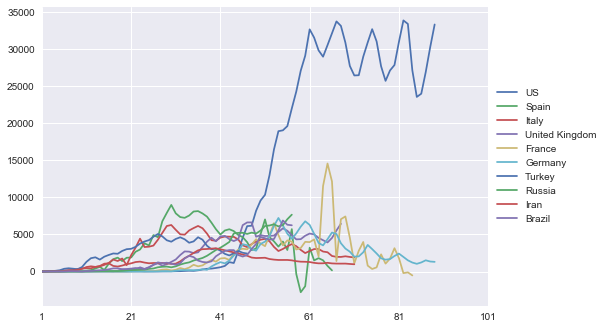

In [51]:
# Visualize the 1st derivative of 10 countries with the highest number of infections
visualize_timeseries(sort_according_to_number_of_infections(df_all_derivative).head(10), False)

Some of the derivatives show cyclic fluctuations on a weekly base. A reason might be that new cases on weekend are reported with delay to the health authorities. Thus, a median filter with a width of 7 (for 7 days per week) is applied to the derivatives before the next step. The filter is implemented in the following function:

In [52]:
def median_filter(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which which is the filtered input dataframe
    
    Description:
    A Savitzky-Golay filter is used for the filtering
    '''

    # Create output dataframe
    df_output = df.copy()
    
    # Iterate over all rows
    for index, row in df_output.iterrows():
        
        # Create a list which is used to call the savgol_filter function
        value_list = []
        
        values_found = False # False as long as the values of the timeseries have not been found

        # Iterate over all columns
        for col_name, col_data in df_output.iteritems():
            if (col_name == '1' or values_found) and not(np.isnan(df_output.at[index, col_name])):
                if not(values_found):
                    values_found = True
                value_list.append(df_output.at[index, col_name]) # Add value to list
        
        # Call the median filter function
        if len(value_list) >= 5:
            value_list = medfilt(value_list, 7) # The 7 encodes the widh. 7 is hard-wired here, since the fluctuations are on a weekly base.

        # Create an iterator to iterate through the medfilt output
        value_liste_iterator = iter(value_list)
        
        # Iterate over all columns
        values_found = False 
        for col_name, col_data in df_output.iteritems():
            if (col_name == '1' or values_found) and not(np.isnan(df_output.at[index, col_name])):
                if not(values_found):
                    values_found = True
                df_output.at[index, col_name] = next(value_liste_iterator) # Write output in output dataframe
                
    return df_output # Return output dataset

In [53]:
# Apply median filter to compensate observed fluctuations on a weekly base
df_all_derivative_filtered = median_filter(df_all_derivative)

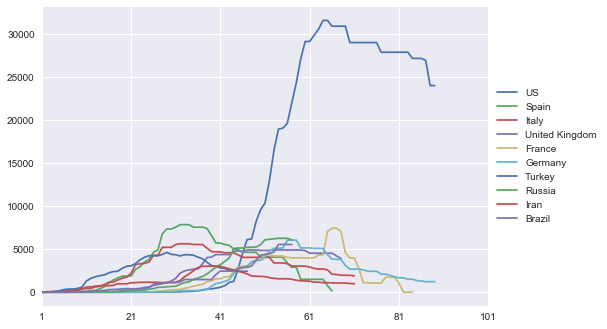

In [54]:
# Visualize the 1st derivative of 10 countries with the highest number of infections after applying the median filter
visualize_timeseries(sort_according_to_number_of_infections(df_all_derivative_filtered).head(10), False)

In [55]:
# To smooth data above, the Savitzky-Golay filter is appplied to the derivative
df_all_derivative_filtered = savitzky_golay_filter(df_all_derivative_filtered)

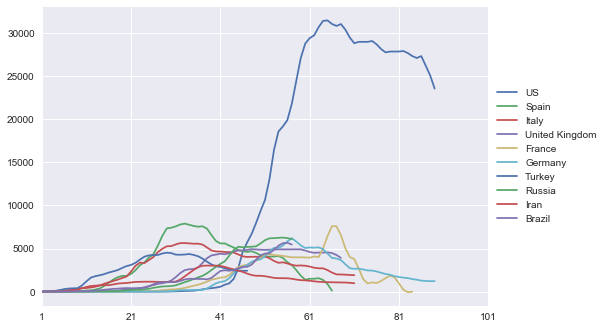

In [56]:
# Visualize the 1st derivative of 15 countries with the highest number of infections after filtering steps
visualize_timeseries(sort_according_to_number_of_infections(df_all_derivative_filtered).head(10), False)

To get the timepoint with the steepest increase of new cases, the second derivative is required. Thus, the function to calculate the derivative is applied again.

In [57]:
# Calculate the 2nd derivative
df_all_2nd_derivative_filtered=derivative(df_all_derivative_filtered)

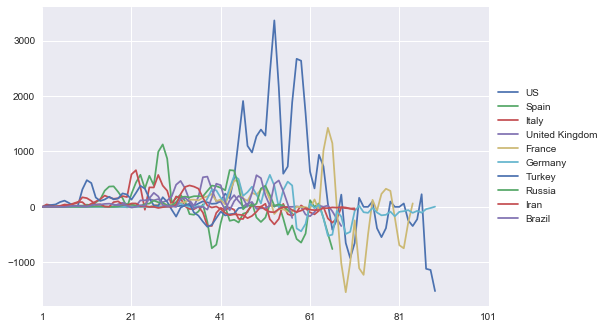

In [58]:
# Visualize the 2nd derivative of the 10 countries with the highest number of infections
visualize_timeseries(sort_according_to_number_of_infections(df_all_2nd_derivative_filtered).head(10), False)

In [59]:
# Apply median and Savitzky-Golay filter to get rid of the spikes
df_all_2nd_derivative_filtered=median_filter(df_all_2nd_derivative_filtered)
df_all_2nd_derivative_filtered=savitzky_golay_filter(df_all_2nd_derivative_filtered)

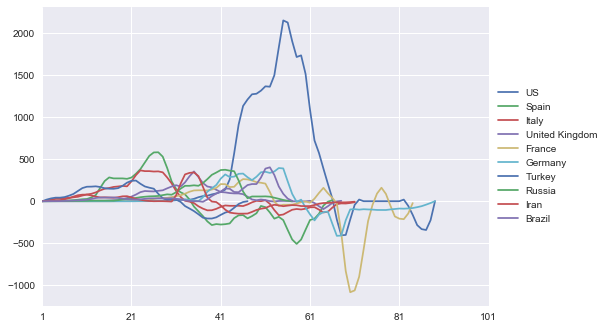

In [60]:
# Visualize the 2nd derivative of the 10 countries with the highest number of infections after filtering steps
visualize_timeseries(sort_according_to_number_of_infections(df_all_2nd_derivative_filtered).head(10), False)

In the next step a function is implemented which calculates the maximum of each row in the timeseries dataframes. Applied to the second derivative, it is the already mentioned point of steepest increase of case numbers.

In [61]:
def add_max_value_and_index(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - input dataframe extended by max value and max index columns
    
    Description:
    Adds two columns
    '''

    # Create output dataframe
    df_output = df.copy()
    
    df_output['Max_Value'] = 0
    df_output['Max_Index'] = 0
    
    # Iterate over all rows
    for index, row in df.iterrows():
        
        # Create an empty list
        value_list = []
        
        values_found = False # False as long as the values of the timeseries have not been found
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if (col_name == '1' or values_found) and not(np.isnan(df_output.at[index, col_name])):
                if not(values_found):
                    values_found = True
                value_list.append(df_output.at[index, col_name])

        # Calculate max value and max index
        max_value = max(value_list)
        max_index = value_list.index(max_value)
        
        df_output.at[index, 'Max_Value'] = max_value
        df_output.at[index, 'Max_Index'] = max_index

    return df_output

In [62]:
# Apply the function to get the max value and the corresponding index and add both to the dataframe
df_all_2nd_derivative_filtered = add_max_value_and_index(df_all_2nd_derivative_filtered)
df_all_2nd_derivative_filtered.head()

Country         pop  density  medianage  urbanpop quarantine  \
0          Afghanistan  38928346.0     60.0       18.0      25.0         50   
1              Albania   2877797.0    105.0       36.0      63.0         50   
2              Algeria  43851044.0     18.0       29.0      73.0         50   
3              Andorra     77265.0    164.0       45.0      88.0         50   
4  Antigua and Barbuda     97929.0    223.0       34.0      26.0         50   

  schools publicplace gathering nonessential  hospibed  smokers  sex0  sex14  \
0      50          50        50           50       0.5      NaN  1.05   1.03   
1      50          50        50           50       2.9     29.4  1.08   1.11   
2      50          50        50           50       1.9      NaN  1.05   1.05   
3      50          50        50           50       2.5     32.5  1.07   1.05   
4      50          50        50           50       3.8      NaN  1.05   1.03   

   sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  malelung  \
0   1.03   1.03   0.97       0.85      1.03  37.62       36.31     39.33   
1   1.09   0.93   0.95       0.87      0.98  11.67        7.02     17.04   
2   1.05   1.03   1.01       0.89      1.03   8.77        5.03     12.81   
3   1.08   1.05   1.15       1.02      1.06    NaN         NaN       NaN   
4   0.99   0.84   0.82       0.76      0.90  11.76        7.67     18.78   

    gdp2019  healthexp  healthperpop  fertility    avgtemp  avghumidity  \
0   18734.0      184.0      4.726633       5.12   6.216667    56.933333   
1   15418.0      774.0    268.955733       1.51  13.950000    69.900000   
2  172781.0     1031.0     23.511413       2.70  19.566667    61.716667   
3   91527.0     5949.0  76994.758300       1.40   7.383333    75.233333   
4    1688.0     1105.0  11283.685120       2.00  19.029371    67.222844   

       Lat     Long  Infections Outbreak_Start         1         2         3  \
0  33.0000  65.0000        2335        3/14/20  0.000443  0.042962  0.142741   
1  41.1533  20.1683         782        3/11/20  0.000000  0.000000  0.000000   
2  28.0339   1.6596        4154         3/4/20  0.000000  0.000000  0.000000   
3  42.5063   1.5218         745        3/17/20  0.244408  1.620408  2.508245   
4  17.0608 -61.7964          25         4/3/20 -0.012501  0.046087  0.086950   

          4         5         6         7         8         9        10  \
0  0.314706  0.479837  0.625190  0.771569  1.032770  1.235895  1.763405   
1  0.003499 -0.010496 -0.033819 -0.037318 -0.033236  0.060688  0.550880   
2  0.000000  0.000000  0.000000 -0.053738  0.161213  0.446274  0.698869   
3  2.650566  2.944560  3.006204  2.900898  2.781551  2.807300  2.474449   
4  0.119417  0.113539  0.108781  0.075475  0.032746 -0.012128 -0.101504   

         11        12        13        14        15        16        17  \
0  2.322519  2.530892  2.255860  2.115405  2.136117  2.138776  2.138776   
1  1.093085  1.351207  1.387942  0.949644  0.329983 -0.113353 -0.012175   
2  0.895440  1.283125  1.540898  1.578612  1.248490  2.582204  4.453878   
3  1.506892  0.617843  0.229085  0.096280 -0.060945 -0.011405  0.004058   
4 -0.213551 -0.181924 -0.061108  0.017073  0.000560  0.000000  0.000000   

         18        19        20        21        22        23        24  \
0  2.165224  2.172222  1.485248  1.083988  1.146169  1.750577  0.925061   
1 -0.012175 -0.040443  0.111254  0.317761  0.464420  0.449306  0.460082   
2  5.758204  5.685294  4.713959  3.090029  1.813621  1.839090  1.570892   
3  0.017703  0.017143 -0.027219 -0.206041 -0.328583 -0.613294 -1.101738   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

         25        26        27        28        29        30        31  \
0  0.640466  0.946472  2.272886  2.895767  2.974134  1.889866  0.914589   
1 -0.049959 -0.685714 -1.052082 -1.056700 -0.652198 -0.141201  0.565015   
2  3.818216  6.817609  8.759860  9.118251  5.727534  0.756875 -2.839557   
3 -1.486694 -1.13

After finding out the value of the steepest slope in the growth curve, it shall also be checked whether there is a way to compare effects of measures against the disease. This is of course not easy since the disease is still spreading. However, here the following criterion is checked: At some point after the maximal growth, the increase becomes slower and the number of additional cases per days decreases. At some point, the maximal number of additional cases per day is reached. This is exactly covered by the maximum of the first derivative. The question is now, how fast this point is reached. The idea is that the faster this goes, the better might be the measures. However, also other effects might play a role here.

In [63]:
# Apply the function to get the max value and the corresponding index and add both to the dataframe
df_all_derivative_filtered = add_max_value_and_index(df_all_derivative_filtered)
df_all_derivative_filtered.head()

Country         pop  density  medianage  urbanpop quarantine  \
0          Afghanistan  38928346.0     60.0       18.0      25.0         50   
1              Albania   2877797.0    105.0       36.0      63.0         50   
2              Algeria  43851044.0     18.0       29.0      73.0         50   
3              Andorra     77265.0    164.0       45.0      88.0         50   
4  Antigua and Barbuda     97929.0    223.0       34.0      26.0         50   

  schools publicplace gathering nonessential  hospibed  smokers  sex0  sex14  \
0      50          50        50           50       0.5      NaN  1.05   1.03   
1      50          50        50           50       2.9     29.4  1.08   1.11   
2      50          50        50           50       1.9      NaN  1.05   1.05   
3      50          50        50           50       2.5     32.5  1.07   1.05   
4      50          50        50           50       3.8      NaN  1.05   1.03   

   sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  malelung  \
0   1.03   1.03   0.97       0.85      1.03  37.62       36.31     39.33   
1   1.09   0.93   0.95       0.87      0.98  11.67        7.02     17.04   
2   1.05   1.03   1.01       0.89      1.03   8.77        5.03     12.81   
3   1.08   1.05   1.15       1.02      1.06    NaN         NaN       NaN   
4   0.99   0.84   0.82       0.76      0.90  11.76        7.67     18.78   

    gdp2019  healthexp  healthperpop  fertility    avgtemp  avghumidity  \
0   18734.0      184.0      4.726633       5.12   6.216667    56.933333   
1   15418.0      774.0    268.955733       1.51  13.950000    69.900000   
2  172781.0     1031.0     23.511413       2.70  19.566667    61.716667   
3   91527.0     5949.0  76994.758300       1.40   7.383333    75.233333   
4    1688.0     1105.0  11283.685120       2.00  19.029371    67.222844   

       Lat     Long  Infections Outbreak_Start         1         2          3  \
0  33.0000  65.0000        2335        3/14/20  0.014694  0.055510   0.345306   
1  41.1533  20.1683         782        3/11/20  0.621224  4.109388   6.030204   
2  28.0339   1.6596        4154         3/4/20  0.060408  0.764082   1.173878   
3  42.5063   1.5218         745        3/17/20 -0.289796  6.382041  11.906939   
4  17.0608 -61.7964          25         4/3/20  0.006531  0.019592   0.130612   

           4          5          6          7          8          9  \
0   0.952653   1.470204   1.622041   2.393469   3.916735   7.244082   
1   5.616327   5.616327   5.555102   5.514286   5.555102   5.430204   
2   1.195918   1.171429   1.171429   1.127347   1.004898   2.327347   
3  16.695510  18.904490  20.773061  23.491429  26.455510  29.703673   
4   0.355918   0.548571   1.005714   1.087347   1.005714   0.721633   

          10         11         12         13         14         15  \
0   9.779592  10.793469  12.130612  15.183673  17.885714  18.622857   
1   5.858776   7.741224  11.726531  14.997551  16.275918  15.957551   
2   4.591020   6.817959   7.444898   7.993469   8.847347  10.409796   
3  33.284082  34.719184  35.150204  31.731429  26.690612  22.951837   
4   0.715102   0.734694   0.509388   0.176327  -0.058776   0.000000   

          16         17         18         19         20         21  \
0  20.792653  22.931429  23.445714  25.275918  31.106122  34.915918   
1  15.942857  15.942857  15.942857  15.925714  15.874286  16.302041   
2  12.023673  17.686531  28.286531  38.220408  43.651429  45.582041   
3  23.576327  23.556735  23.571429  23.583673  23.811429  22.666939   
4   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

          22         23         24         25         26         27  \
0  34.444082  32.093061  31.884082  33.400816  36.444082  38.404898   
1  17.648163  18.957551  19.435102  19.611429  18.656327  15.419592   
2  46.328980  47.061224  49.525714  49.480816  58.628571  85.293878   
3  20.993469  19.434286  19.262041  18.816327  18.395102  15.306122   
4   0.000000   0.000000   0.

With the previously calculated maximum values it is now possible to derive the discussed measure values to compare growth and effect of measures between different countries. For this, the following two functions are used.

In [64]:
def calc_spreading_factor(df_all, df_2nd_derivative):
    '''
    INPUT:
    df_all - pandas dataframe with timeseries
    df_2nd_derivative - pandas dataframe with the 2nd derivative of the timeseries
    
    Description:
    Adds a column with the cummulative case value at which the 2nd derivative has its maximum ('Max_Value').
    Additionally, the corresponding index is stored ('Max_Index').
    Calculates the growth factor till reaching the max value. Result is stored in 'Spreading_Factor'.
    '''

    df_all['Max_Index'] = 0

    # Iterate over all rows
    for index, row in df_all.iterrows():
        
        values_found = False # False as long as the values of the timeseries have not been found

        # Iterate over all columns
        index_counter = 0
        for col_name, col_data in df_all.iteritems():
            if (col_name == '1' or values_found) and not(np.isnan(df_all.at[index, col_name])):
                if not(values_found):
                    values_found = True
                if index_counter == df_2nd_derivative.at[index, 'Max_Index']:
                    df_all.at[index, 'Max_Index'] = df_2nd_derivative.at[index, 'Max_Index']
                    df_all.at[index, 'Max_Value'] = df_all.at[index, col_name]
                index_counter = index_counter + 1

    # Caluculate the spreading factor
    df_all['Spreading_Factor'] = (df_all['Max_Value'] / df_all['1'])**(1.0 / df_2nd_derivative['Max_Index'])

In [65]:
def calc_measure_effect(df_all, df_derivative):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    df_derivative - pandas dataframe with the derivative of the timeseries
    
    Description:
    Calculates the number of days between reaching the steepest increase in growth till the maximal number of cases per day
    The shorter the number, the better are obviously the measures in this model.
    '''

    df_all['Days_till_Max'] = 0

    # Iterate over all rows
    for index, row in df_all.iterrows():
        df_all.at[index, 'Days_till_Max'] = df_derivative.at[index, 'Max_Index'] - df_all.at[index, 'Max_Index']
        df_all.at[index, 'Max_new_cases'] = df_derivative.at[index, 'Max_Value']

In [66]:
# Calculate the spreading factor (added to df_all)
calc_spreading_factor(df_all, df_all_2nd_derivative_filtered)

In [67]:
# Calculate the effect of measures (added to df_all)
calc_measure_effect(df_all, df_all_derivative_filtered)

In [68]:
# Show the spreading factor in in a decreasing manner
df_all.sort_values(by = 'Spreading_Factor', ascending = False)

Country           pop  density  medianage  \
22                             Brunei  4.374790e+05     83.0       32.0   
25                         Cabo Verde  5.544410e+05    138.0       27.6   
52                            Estonia  1.326535e+06     31.0       42.0   
117                             Niger  2.420664e+07     19.0       15.2   
97                         Luxembourg  6.259780e+05    242.0       40.0   
142                          Slovakia  5.459642e+06    114.0       41.0   
143                          Slovenia  2.078938e+06    103.0       45.0   
115                       New Zealand  4.822233e+06     18.0       38.0   
32                              China  1.439324e+09    153.0       38.0   
46                 Dominican Republic  1.084791e+07    225.0       28.0   
160                            Turkey  8.433907e+07    110.0       32.0   
83                             Jordan  1.020313e+07    115.0       24.0   
104                         Mauritius  1.271768e+06    626.0       37.0   
166                           Uruguay  3.473730e+06     20.0       36.0   
80                              Italy  6.046183e+07    206.0       47.0   
128                          Portugal  1.019671e+07    111.0       46.0   
107                            Monaco  3.924200e+04  26337.0       54.0   
146                             Spain  4.675478e+07     94.0       45.0   
24                       Burkina Faso  2.090327e+07     76.0       18.0   
151                       Switzerland  8.654622e+06    219.0       43.0   
123                            Panama  4.314767e+06     58.0       30.0   
31                              Chile  1.911620e+07     26.0       35.0   
8                             Austria  9.006398e+06    109.0       43.0   
15                            Belgium  1.158962e+07    383.0       42.0   
144                           Somalia  1.589322e+07     25.0       17.0   
114                       Netherlands  1.713487e+07    508.0       43.0   
96                          Lithuania  2.722289e+06     43.0       45.0   
6                             Armenia  2.963243e+06    104.0       35.0   
41                            Czechia  1.070898e+07    139.0       43.0   
56                            Finland  5.540720e+06     18.0       43.0   
79                             Israel  8.655535e+06    400.0       30.0   
120                            Norway  5.421241e+06     15.0       40.0   
127                            Poland  3.784661e+07    124.0       42.0   
37                      Cote d'Ivoire  2.637827e+07     83.0       19.0   
98                         Madagascar  2.769102e+07     48.0       19.6   
139                            Serbia  8.737371e+06    100.0       42.0   
72                            Hungary  9.660351e+06    107.0       43.0   
3                             Andorra  7.726500e+04    164.0       45.0   
27                           Cameroon  2.654586e+07     56.0       19.0   
76                               Iran  8.399295e+07     52.0       32.0   
91                             Latvia  1.886198e+06     30.0       44.0   
165                    United Kingdom  6.788601e+07    281.0       40.0   
63                             Greece  1.042305e+07     81.0       46.0   
129                             Qatar  2.881053e+06    248.0       32.0   
126                       Philippines  1.095811e+08    368.0       26.0   
36                         Costa Rica  5.094118e+06    100.0       33.0   
93                            Liberia  5.057681e+06     53.0       19.0   
73                            Iceland  3.412430e+05      3.0       37.0   
42                            Denmark  5.792202e+06    137.0       42.0   
20             Bosnia and Herzegovina  3.280819e+06     64.0       43.0   
5                           Argentina  4.519577e+07     17.0       32.0   
130                           Romania  1.923769e+07     84.0       43.0   
43                   Diamond Princess  3.500000e+03    

### Check correlation between measures

In the next step the correlation between different features and the measure values derived from the data is calculated and visualized.

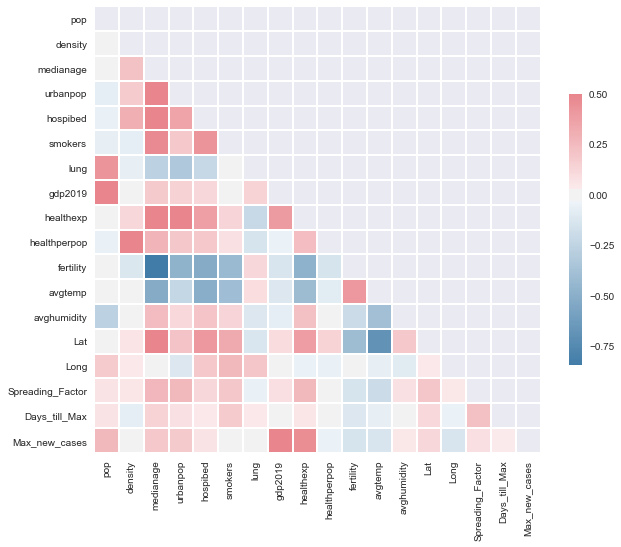

In [69]:
# Create a new dataframe consisting of the columns to be checked for correlation
# Note: The code below has been taken from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
df_plot = df_all[['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'smokers', 'lung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'Spreading_Factor', 'Days_till_Max', 'Max_new_cases']]

# Compute the correlation matrix
corr = df_plot.corr()

# Generate a mask
mask = np.triu(np.ones_like(corr, dtype = np.bool))

# Create the matplotlib figure
f, ax = plt.subplots(figsize = (10, 10))

# Generate a colormap
cmap = sns.diverging_palette(240, 10, as_cmap = True)

# Draw the heatmap
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.5, center = 0,
            square = True, linewidths = 1.0, cbar_kws = {"shrink": 0.5})

Create scatterplot for those features for which a slight correlation can be observed.

Pearson correlation coefficient:
-0.1331889168437555


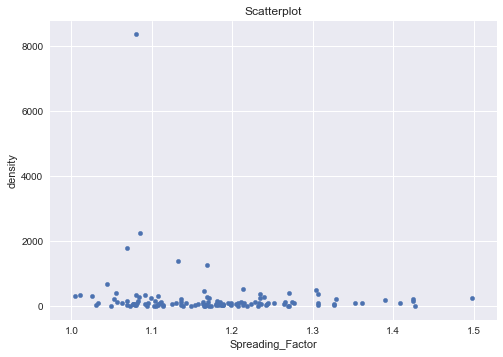

In [70]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'density')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['density']))

Pearson correlation coefficient:
0.38659471738175805


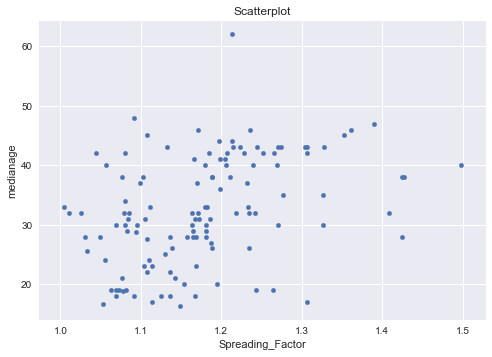

In [71]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'medianage')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['medianage']))

Pearson correlation coefficient:
0.2968293478286854


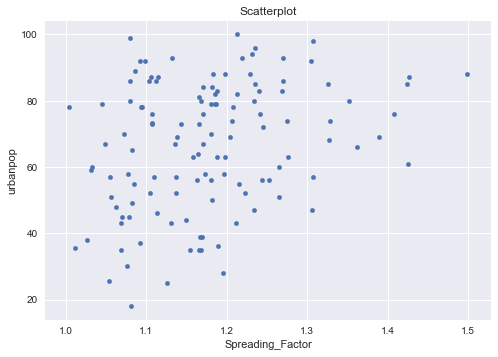

In [72]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'urbanpop')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['urbanpop']))

Pearson correlation coefficient:
0.24582316406182758


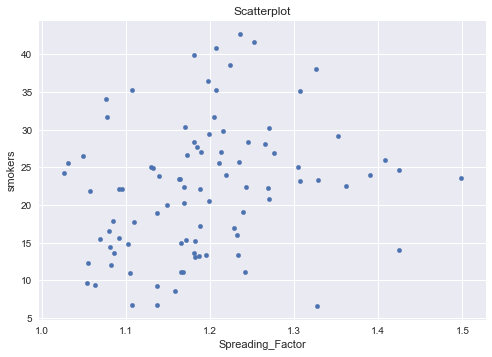

In [73]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'smokers')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['smokers']))

Pearson correlation coefficient:
0.013555646966362618


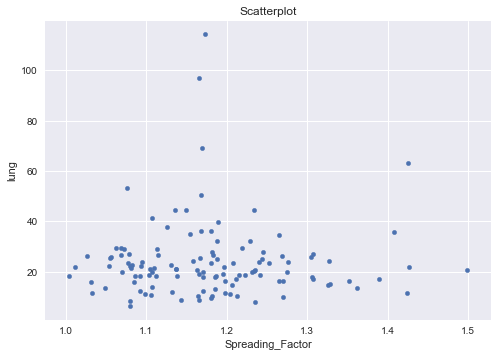

In [74]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'lung')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['lung']))

Pearson correlation coefficient:
0.16702642638244936


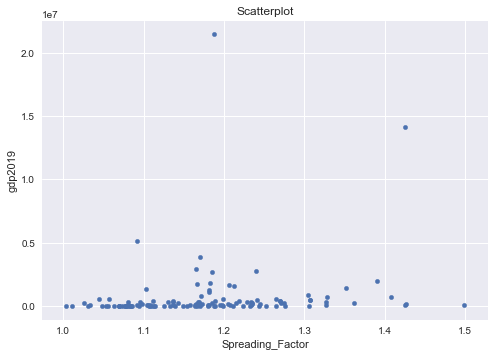

In [75]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'gdp2019')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['gdp2019']))

Pearson correlation coefficient:
0.08107041862088812


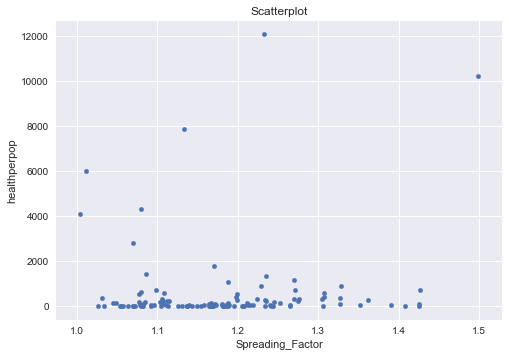

In [76]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'healthperpop')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['healthperpop']))

Pearson correlation coefficient:
-0.26161057514360525


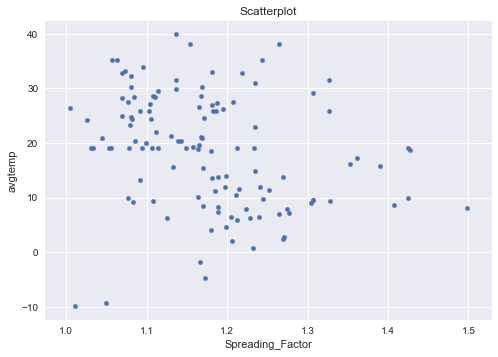

In [77]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'avgtemp')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['avgtemp']))

Pearson correlation coefficient:
-0.0228115064523996


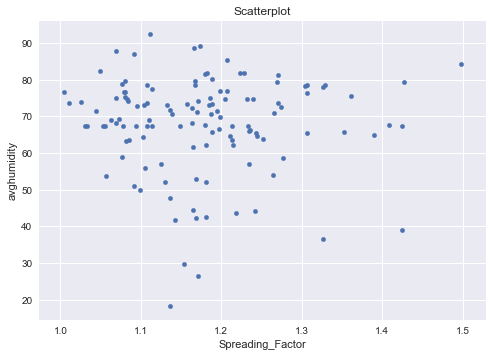

In [78]:
# Create a scatterplot
df_plot = df_all.replace([np.inf, -np.inf], np.nan)
df_plot = df_plot[df_plot['Spreading_Factor'] > 1.0]
df_plot = df_plot[df_plot['Max_Index'] >= minimal_exponential_phase]
df_plot.plot.scatter(x = 'Spreading_Factor', y = 'avghumidity')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Spreading_Factor'].corr(df_plot['avghumidity']))

Pearson correlation coefficient:
-0.08163675501328645


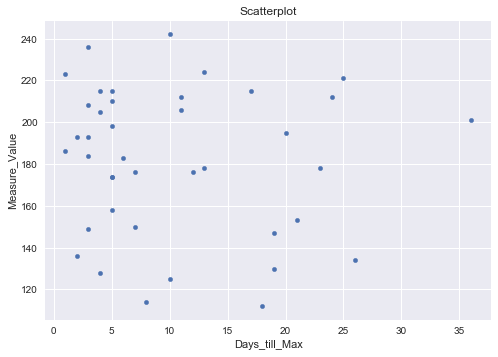

In [79]:
# Create a scatterplot
df_plot = df_all.copy()
df_plot['Measure_Value']=df_all['quarantine']+df_all['schools']+df_all['publicplace']+df_all['gathering']+df_all['nonessential']
df_plot['Measure_Value'] = df_plot['Measure_Value'].astype(int)
df_plot = df_plot[df_plot['Measure_Value'] < (penality * 5)]
df_plot.plot.scatter(x = 'Days_till_Max', y = 'Measure_Value')
plt.title("Scatterplot")
print('Pearson correlation coefficient:')
print(df_plot['Days_till_Max'].corr(df_plot['Measure_Value']))

### Is it possible to predicted the growth rate of an outbreak?
In the next step, machine learning is used to check whether it is possible to predict the spreading factor just form the information about the country.

In [80]:
# Create dataset for machine learning model to predict the Spreading Factor
df_ml = df_all.copy()
df_ml = df_ml.set_index('Country')
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
print("Remaining countries in dataset after converting inf to nan: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml[df_ml['Spreading_Factor'] > 1.0] # Take only those countries with a spreading factor > 1.0 (where an outbreak was detected)
print("Remaining countries in dataset after removal of rows with growth factor <= 1.0: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml[df_ml['Max_Index'] >= minimal_exponential_phase]
print("Remaining countries in dataset after removal of rows with to short exponential phase: ", df_ml.shape[0], "/", df_all.shape[0])

# Remark: Smokers are not considered since there are too many nans. Thus, the column will not be used
df_ml = df_ml.dropna(subset=['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'Spreading_Factor'])
print("Remaining countries in dataset after removal of rows with nan: ", df_ml.shape[0], "/", df_all.shape[0])

# Create X and y
X = df_ml[['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long']]
y = df_ml['Spreading_Factor']
X.head()


Remaining countries in dataset after converting inf to nan:  172 / 172
Remaining countries in dataset after removal of rows with growth factor <= 1.0:  165 / 172
Remaining countries in dataset after removal of rows with to short exponential phase:  123 / 172
Remaining countries in dataset after removal of rows with nan:  118 / 172


pop  density  medianage  urbanpop  hospibed  sex0  sex14  \
Country                                                                        
Afghanistan  38928346.0     60.0       18.0      25.0       0.5  1.05   1.03   
Albania       2877797.0    105.0       36.0      63.0       2.9  1.08   1.11   
Algeria      43851044.0     18.0       29.0      73.0       1.9  1.05   1.05   
Argentina    45195774.0     17.0       32.0      93.0       5.0  1.05   1.06   
Armenia       2963243.0    104.0       35.0      63.0       4.2  1.13   1.14   

             sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  \
Country                                                                    
Afghanistan   1.03   1.03   0.97       0.85      1.03  37.62       36.31   
Albania       1.09   0.93   0.95       0.87      0.98  11.67        7.02   
Algeria       1.05   1.03   1.01       0.89      1.03   8.77        5.03   
Argentina     1.05   1.00   0.94       0.71      0.98  29.27       20.16   
Armenia       1.06   0.93   0.84       0.67      0.94  23.86       16.17   

             malelung   gdp2019  healthexp  healthperpop  fertility  \
Country                                                               
Afghanistan     39.33   18734.0      184.0      4.726633       5.12   
Albania         17.04   15418.0      774.0    268.955733       1.51   
Algeria         12.81  172781.0     1031.0     23.511413       2.70   
Argentina       42.59  445469.0     1390.0     30.755088       2.26   
Armenia         35.99   13444.0      883.0    297.984337       1.64   

               avgtemp  avghumidity      Lat     Long  
Country                                                
Afghanistan   6.216667    56.933333  33.0000  65.0000  
Albania      13.950000    69.900000  41.1533  20.1683  
Algeria      19.566667    61.716667  28.0339   1.6596  
Argentina    32.816667    43.616667 -38.4161 -63.6167  
Armenia       7.100000    58.500000  40.0691  45.0382

In [81]:
# Random forest regression

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Instantiate
rfr_model = RandomForestRegressor(n_estimators = 10000, max_depth = 16, random_state = 42)

# Fit
rfr_model.fit(X_train, y_train) 

# Predict on train (to get the r2 value for comparison)
y_train_preds = rfr_model.predict(X_train)

# Rsquared here for comparing train and preds from model
r2_train = r2_score(y_train, y_train_preds)

# Print r2 to see result on test data
print('The R^2 value on train is:', r2_train)

# Predict
y_test_preds = rfr_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test = r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value on test is:', r2_test)

The R^2 value on train is: 0.8847775607804949
The R^2 value on test is: -0.36076952601971946


### Is it possible to predict the effect of measures against an outbreak?

In the next step, machine learning is used to check whether it is possible to predict the effect of measures against the disease.

In [82]:
# Create dataset for machine learning model to predict the effect of the measures
df_ml = df_all.copy()
df_ml = df_ml.set_index('Country')
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
print("Remaining countries in dataset after converting inf to nan: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml[df_ml['Max_Index'] >= minimal_exponential_phase]
print("Remaining countries in dataset after removal of rows with to short exponential phase: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml.dropna(subset=['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', 'Spreading_Factor', 'Days_till_Max'])
print("Remaining countries in dataset after removal of rows with nan: ", df_ml.shape[0], "/", df_all.shape[0])

# Create X and y
X = df_ml[['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', 'Spreading_Factor']]
y = df_ml['Days_till_Max']
X.head()


Remaining countries in dataset after converting inf to nan:  172 / 172
Remaining countries in dataset after removal of rows with to short exponential phase:  123 / 172
Remaining countries in dataset after removal of rows with nan:  118 / 172


pop  density  medianage  urbanpop  hospibed  sex0  sex14  \
Country                                                                        
Afghanistan  38928346.0     60.0       18.0      25.0       0.5  1.05   1.03   
Albania       2877797.0    105.0       36.0      63.0       2.9  1.08   1.11   
Algeria      43851044.0     18.0       29.0      73.0       1.9  1.05   1.05   
Argentina    45195774.0     17.0       32.0      93.0       5.0  1.05   1.06   
Armenia       2963243.0    104.0       35.0      63.0       4.2  1.13   1.14   

             sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  \
Country                                                                    
Afghanistan   1.03   1.03   0.97       0.85      1.03  37.62       36.31   
Albania       1.09   0.93   0.95       0.87      0.98  11.67        7.02   
Algeria       1.05   1.03   1.01       0.89      1.03   8.77        5.03   
Argentina     1.05   1.00   0.94       0.71      0.98  29.27       20.16   
Armenia       1.06   0.93   0.84       0.67      0.94  23.86       16.17   

             malelung   gdp2019  healthexp  healthperpop  fertility  \
Country                                                               
Afghanistan     39.33   18734.0      184.0      4.726633       5.12   
Albania         17.04   15418.0      774.0    268.955733       1.51   
Algeria         12.81  172781.0     1031.0     23.511413       2.70   
Argentina       42.59  445469.0     1390.0     30.755088       2.26   
Armenia         35.99   13444.0      883.0    297.984337       1.64   

               avgtemp  avghumidity      Lat     Long  quarantine  schools  \
Country                                                                      
Afghanistan   6.216667    56.933333  33.0000  65.0000          50       50   
Albania      13.950000    69.900000  41.1533  20.1683          50       50   
Algeria      19.566667    61.716667  28.0339   1.6596          50       50   
Argentina    32.816667    43.616667 -38.4161 -63.6167          12       50   
Armenia       7.100000    58.500000  40.0691  45.0382          50       50   

             publicplace  gathering  nonessential  Spreading_Factor  
Country                                                              
Afghanistan           50         50            50          1.125267  
Albania               50         50            50          1.198285  
Algeria               50         50            50          1.165143  
Argentina             50         50            50          1.218634  
Armenia               50         50            50          1.276428

In [83]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Instantiate
rfr_model = RandomForestRegressor(n_estimators=10000, max_depth = 16, random_state = 42)

# Fit
rfr_model.fit(X_train, y_train) 

# Predict on train (to get the r2 value for comparison)
y_train_preds = rfr_model.predict(X_train)

# Rsquared here for comparing train and preds from model
r2_train = r2_score(y_train, y_train_preds)

# Print r2 to see result on test data
print('The R^2 value on train is:', r2_train)

# Predict
y_test_preds = rfr_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test = r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value on test is:', r2_test)

The R^2 value on train is: 0.8497787145209617
The R^2 value on test is: -0.14826786339809028


### Predict maximum number of new cases by using early case numbers
In an additional approach, case numbers from the first weeks are used additionally to predict the maximum number of cases per day. This is relevant since it gives an estimation which capacity of intensive care units is required. Thus, countries can prepare for the maximum in the early days of the epedemics.

#### Predict maximum number of new cases by using the case numbers of the first week

In [84]:
# Create dataset for machine learning model to predict the maximum number of new cases from data of the first week 
df_ml = df_all.copy()
df_ml = df_ml.set_index('Country')
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
print("Remaining countries in dataset after converting inf to nan: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml[df_ml['Max_Index'] >= minimal_exponential_phase]
print("Remaining countries in dataset after removal of rows with to short exponential phase: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml.dropna(subset=['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', '1', '2', '3', '4', '5', '6', '7', 'Max_new_cases'])
print("Remaining countries in dataset after removal of rows with nan: ", df_ml.shape[0], "/", df_all.shape[0])

# Create X and y
X = df_ml[['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', '1', '2', '3', '4', '5', '6', '7']]
y = df_ml['Max_new_cases']
X.head()

Remaining countries in dataset after converting inf to nan:  172 / 172
Remaining countries in dataset after removal of rows with to short exponential phase:  123 / 172
Remaining countries in dataset after removal of rows with nan:  118 / 172


pop  density  medianage  urbanpop  hospibed  sex0  sex14  \
Country                                                                        
Afghanistan  38928346.0     60.0       18.0      25.0       0.5  1.05   1.03   
Albania       2877797.0    105.0       36.0      63.0       2.9  1.08   1.11   
Algeria      43851044.0     18.0       29.0      73.0       1.9  1.05   1.05   
Argentina    45195774.0     17.0       32.0      93.0       5.0  1.05   1.06   
Armenia       2963243.0    104.0       35.0      63.0       4.2  1.13   1.14   

             sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  \
Country                                                                    
Afghanistan   1.03   1.03   0.97       0.85      1.03  37.62       36.31   
Albania       1.09   0.93   0.95       0.87      0.98  11.67        7.02   
Algeria       1.05   1.03   1.01       0.89      1.03   8.77        5.03   
Argentina     1.05   1.00   0.94       0.71      0.98  29.27       20.16   
Armenia       1.06   0.93   0.84       0.67      0.94  23.86       16.17   

             malelung   gdp2019  healthexp  healthperpop  fertility  \
Country                                                               
Afghanistan     39.33   18734.0      184.0      4.726633       5.12   
Albania         17.04   15418.0      774.0    268.955733       1.51   
Algeria         12.81  172781.0     1031.0     23.511413       2.70   
Argentina       42.59  445469.0     1390.0     30.755088       2.26   
Armenia         35.99   13444.0      883.0    297.984337       1.64   

               avgtemp  avghumidity      Lat     Long  quarantine  schools  \
Country                                                                      
Afghanistan   6.216667    56.933333  33.0000  65.0000          50       50   
Albania      13.950000    69.900000  41.1533  20.1683          50       50   
Algeria      19.566667    61.716667  28.0339   1.6596          50       50   
Argentina    32.816667    43.616667 -38.4161 -63.6167          12       50   
Armenia       7.100000    58.500000  40.0691  45.0382          50       50   

             publicplace  gathering  nonessential          1          2  \
Country                                                                   
Afghanistan           50         50            50  10.800000  16.600000   
Albania               50         50            50  11.885714  23.457143   
Algeria               50         50            50  11.457143  13.571429   
Argentina             50         50            50  11.171429  13.914286   
Armenia               50         50            50  14.228571  33.485714   

                     3          4          5           6           7  
Country                                                               
Afghanistan  20.400000  22.171429  21.914286   22.514286   22.114286  
Albania      32.314286  37.828571  43.371429   49.714286   55.342857  
Algeria      15.542857  17.857143  18.742857   19.914286   19.742857  
Argentina    16.228571  17.885714  22.000000   27.742857   36.142857  
Armenia      52.171429  72.428571  90.857143  110.885714  136.514286

In [85]:
# Random forest regression

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Instantiate
rfr_model = RandomForestRegressor(n_estimators = 10000, max_depth = 16, random_state = 42)

# Fit
rfr_model.fit(X_train, y_train) 

# Predict on train (to get the r2 value for comparison)
y_train_preds = rfr_model.predict(X_train)

# Rsquared here for comparing train and preds from model
r2_train = r2_score(y_train, y_train_preds)

# Print r2 to see result on test data
print('The R^2 value on train is:', r2_train)

# Predict
y_test_preds = rfr_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test = r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value on test is:', r2_test)

The R^2 value on train is: 0.9137109963347936
The R^2 value on test is: 0.22197400316082594


#### Predict maximum number of new cases by using the case numbers of the first two weeks

In [86]:
# Create dataset for machine learning model to predict the maximum number of new cases from data of the first two weeks
df_ml = df_all.copy()
df_ml = df_ml.set_index('Country')
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
print("Remaining countries in dataset after converting inf to nan: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml[df_ml['Max_Index'] >= minimal_exponential_phase]
print("Remaining countries in dataset after removal of rows with to short exponential phase: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml.dropna(subset=['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 'Max_new_cases'])
print("Remaining countries in dataset after removal of rows with nan: ", df_ml.shape[0], "/", df_all.shape[0])

# Create X and y
X = df_ml[['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']]
y = df_ml['Max_new_cases']
X.head()

Remaining countries in dataset after converting inf to nan:  172 / 172
Remaining countries in dataset after removal of rows with to short exponential phase:  123 / 172
Remaining countries in dataset after removal of rows with nan:  118 / 172


pop  density  medianage  urbanpop  hospibed  sex0  sex14  \
Country                                                                        
Afghanistan  38928346.0     60.0       18.0      25.0       0.5  1.05   1.03   
Albania       2877797.0    105.0       36.0      63.0       2.9  1.08   1.11   
Algeria      43851044.0     18.0       29.0      73.0       1.9  1.05   1.05   
Argentina    45195774.0     17.0       32.0      93.0       5.0  1.05   1.06   
Armenia       2963243.0    104.0       35.0      63.0       4.2  1.13   1.14   

             sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  \
Country                                                                    
Afghanistan   1.03   1.03   0.97       0.85      1.03  37.62       36.31   
Albania       1.09   0.93   0.95       0.87      0.98  11.67        7.02   
Algeria       1.05   1.03   1.01       0.89      1.03   8.77        5.03   
Argentina     1.05   1.00   0.94       0.71      0.98  29.27       20.16   
Armenia       1.06   0.93   0.84       0.67      0.94  23.86       16.17   

             malelung   gdp2019  healthexp  healthperpop  fertility  \
Country                                                               
Afghanistan     39.33   18734.0      184.0      4.726633       5.12   
Albania         17.04   15418.0      774.0    268.955733       1.51   
Algeria         12.81  172781.0     1031.0     23.511413       2.70   
Argentina       42.59  445469.0     1390.0     30.755088       2.26   
Armenia         35.99   13444.0      883.0    297.984337       1.64   

               avgtemp  avghumidity      Lat     Long  quarantine  schools  \
Country                                                                      
Afghanistan   6.216667    56.933333  33.0000  65.0000          50       50   
Albania      13.950000    69.900000  41.1533  20.1683          50       50   
Algeria      19.566667    61.716667  28.0339   1.6596          50       50   
Argentina    32.816667    43.616667 -38.4161 -63.6167          12       50   
Armenia       7.100000    58.500000  40.0691  45.0382          50       50   

             publicplace  gathering  nonessential          1          2  \
Country                                                                   
Afghanistan           50         50            50  10.800000  16.600000   
Albania               50         50            50  11.885714  23.457143   
Algeria               50         50            50  11.457143  13.571429   
Argentina             50         50            50  11.171429  13.914286   
Armenia               50         50            50  14.228571  33.485714   

                     3          4          5           6           7  \
Country                                                                
Afghanistan  20.400000  22.171429  21.914286   22.514286   22.114286   
Albania      32.314286  37.828571  43.371429   49.714286   55.342857   
Algeria      15.542857  17.857143  18.742857   19.914286   19.742857   
Argentina    16.228571  17.885714  22.000000   27.742857   36.142857   
Armenia      52.171429  72.428571  90.857143  110.885714  136.514286   

                      8           9          10          11          12  \
Country                                                                   
Afghanistan   28.285714   32.971429   49.257143   66.971429   85.542857   
Albania       59.085714   64.085714   69.314286   77.028571   88.400000   
Algeria       20.857143   22.542857   27.714286   36.657143   47.142857   
Argentina     44.228571   56.257143   67.142857   79.171429   98.714286   
Armenia      160.857143  196.657143  229.600000  250.885714  265.171429   

                     13          14  
Country                              
Afghanistan   96.400000  105.885714  
Albania      104.171429  122.914286  
Algeria       53.742857   61.457143  
Argentina    120.028571  177.714286  
Armenia      288.285714  339.714286

In [87]:
# Random forest regression

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Instantiate
rfr_model = RandomForestRegressor(n_estimators = 10000, max_depth = 16, random_state = 42)

# Fit
rfr_model.fit(X_train, y_train) 

# Predict on train (to get the r2 value for comparison)
y_train_preds = rfr_model.predict(X_train)

# Rsquared here for comparing train and preds from model
r2_train = r2_score(y_train, y_train_preds)

# Print r2 to see result on test data
print('The R^2 value on train is:', r2_train)

# Predict
y_test_preds = rfr_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test = r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value on test is:', r2_test)

The R^2 value on train is: 0.9204245964555839
The R^2 value on test is: 0.21115334549715203


#### Predict maximum number of new cases by using the case numbers of the first three weeks

In [88]:
# Create dataset for machine learning model to predict the maximum number of new cases from data of the first three weeks
df_ml = df_all.copy()
df_ml = df_ml.set_index('Country')
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
print("Remaining countries in dataset after converting inf to nan: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml[df_ml['Max_Index'] >= minimal_exponential_phase]
print("Remaining countries in dataset after removal of rows with to short exponential phase: ", df_ml.shape[0], "/", df_all.shape[0])

df_ml = df_ml.dropna(subset=['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', 'Max_new_cases'])
print("Remaining countries in dataset after removal of rows with nan: ", df_ml.shape[0], "/", df_all.shape[0])

# Create X and y
X = df_ml[['pop', 'density', 'medianage', 'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019', 'healthexp', 'healthperpop', 'fertility', 'avgtemp', 'avghumidity', 'Lat', 'Long', 'quarantine', 'schools', 'publicplace', 'gathering', 'nonessential', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']]
y = df_ml['Max_new_cases']
X.head()

Remaining countries in dataset after converting inf to nan:  172 / 172
Remaining countries in dataset after removal of rows with to short exponential phase:  123 / 172
Remaining countries in dataset after removal of rows with nan:  118 / 172


pop  density  medianage  urbanpop  hospibed  sex0  sex14  \
Country                                                                        
Afghanistan  38928346.0     60.0       18.0      25.0       0.5  1.05   1.03   
Albania       2877797.0    105.0       36.0      63.0       2.9  1.08   1.11   
Algeria      43851044.0     18.0       29.0      73.0       1.9  1.05   1.05   
Argentina    45195774.0     17.0       32.0      93.0       5.0  1.05   1.06   
Armenia       2963243.0    104.0       35.0      63.0       4.2  1.13   1.14   

             sex25  sex54  sex64  sex65plus  sexratio   lung  femalelung  \
Country                                                                    
Afghanistan   1.03   1.03   0.97       0.85      1.03  37.62       36.31   
Albania       1.09   0.93   0.95       0.87      0.98  11.67        7.02   
Algeria       1.05   1.03   1.01       0.89      1.03   8.77        5.03   
Argentina     1.05   1.00   0.94       0.71      0.98  29.27       20.16   
Armenia       1.06   0.93   0.84       0.67      0.94  23.86       16.17   

             malelung   gdp2019  healthexp  healthperpop  fertility  \
Country                                                               
Afghanistan     39.33   18734.0      184.0      4.726633       5.12   
Albania         17.04   15418.0      774.0    268.955733       1.51   
Algeria         12.81  172781.0     1031.0     23.511413       2.70   
Argentina       42.59  445469.0     1390.0     30.755088       2.26   
Armenia         35.99   13444.0      883.0    297.984337       1.64   

               avgtemp  avghumidity      Lat     Long  quarantine  schools  \
Country                                                                      
Afghanistan   6.216667    56.933333  33.0000  65.0000          50       50   
Albania      13.950000    69.900000  41.1533  20.1683          50       50   
Algeria      19.566667    61.716667  28.0339   1.6596          50       50   
Argentina    32.816667    43.616667 -38.4161 -63.6167          12       50   
Armenia       7.100000    58.500000  40.0691  45.0382          50       50   

             publicplace  gathering  nonessential          1          2  \
Country                                                                   
Afghanistan           50         50            50  10.800000  16.600000   
Albania               50         50            50  11.885714  23.457143   
Algeria               50         50            50  11.457143  13.571429   
Argentina             50         50            50  11.171429  13.914286   
Armenia               50         50            50  14.228571  33.485714   

                     3          4          5           6           7  \
Country                                                                
Afghanistan  20.400000  22.171429  21.914286   22.514286   22.114286   
Albania      32.314286  37.828571  43.371429   49.714286   55.342857   
Algeria      15.542857  17.857143  18.742857   19.914286   19.742857   
Argentina    16.228571  17.885714  22.000000   27.742857   36.142857   
Armenia      52.171429  72.428571  90.857143  110.885714  136.514286   

                      8           9          10          11          12  \
Country                                                                   
Afghanistan   28.285714   32.971429   49.257143   66.971429   85.542857   
Albania       59.085714   64.085714   69.314286   77.028571   88.400000   
Algeria       20.857143   22.542857   27.714286   36.657143   47.142857   
Argentina     44.228571   56.257143   67.142857   79.171429   98.714286   
Armenia      160.857143  196.657143  229.600000  250.885714  265.171429   

                     13          14          15          16          17  \
Country                                                                   
Afghanistan   96.400000  105.885714  109.657143  129.942857  153.628571   
Albania      104.171429  122.914286  147.885714  170.914286  186.857143   
Algeria       53.742857 

In [89]:
# Random forest regression

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

# Instantiate
rfr_model = RandomForestRegressor(n_estimators = 10000, max_depth = 16, random_state = 42)

# Fit
rfr_model.fit(X_train, y_train) 

# Predict on train (to get the r2 value for comparison)
y_train_preds = rfr_model.predict(X_train)

# Rsquared here for comparing train and preds from model
r2_train = r2_score(y_train, y_train_preds)

# Print r2 to see result on test data
print('The R^2 value on train is:', r2_train)

# Predict
y_test_preds = rfr_model.predict(X_test)

# Rsquared here for comparing test and preds from model
r2_test = r2_score(y_test, y_test_preds)

# Print r2 to see result on test data
print('The R^2 value on test is:', r2_test)

The R^2 value on train is: 0.9246076079228153
The R^2 value on test is: 0.2069904808507077


## 5. Conclusion

The results show that it is not an easy problem to predict the development of the COVID-19 disease. However, they also show that if you observe the growth over the first days and weeks, you get an idea of what might come, e.g. to prepare the health system for it.

A more detailled discussion can be found in my corresponding [blog post](https://mirods.github.io/project4.html).